In [5]:
%env ALL_PROXY=http://127.0.0.1:33001
%env HTTP_PROXY=http://127.0.0.1:33001
%env HTTPS_PROXY=http://127.0.0.1:33001

env: ALL_PROXY=http://127.0.0.1:33001
env: HTTP_PROXY=http://127.0.0.1:33001
env: HTTPS_PROXY=http://127.0.0.1:33001


In [6]:
!curl google.com

<HTML><HEAD><meta http-equiv="content-type" content="text/html;charset=utf-8">
<TITLE>301 Moved</TITLE></HEAD><BODY>
<H1>301 Moved</H1>
The document has moved
<A HREF="http://www.google.com/">here</A>.
</BODY></HTML>


# Import

If change the model, in training step, you need to 
1. change the log chapter
2. change the model code
3. change the wandb chapter

In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from sklearn.model_selection import KFold, train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import wandb

In [8]:
import sys
sys.path.insert(0, "/root/Soil-Column-Procedures")

from API_functions.DL import load_data, log, seed, evaluate
from API_functions import file_batch as fb

# Hyperparameter and log

In [9]:
my_parameters = {
    'seed': 409,

    'Kfold': None,
    'ratio': 0.2,

    'model': 'PSPNet',   # model = 'U-Net', 'DeepLabv3+', 'PSPNet'
    'optimizer': 'adam',
    'learning_rate':  0.0001,
    'batch_size': 32,
    'loss_function': 'cross_entropy',

    'n_epochs': 1000,
    'patience': 50,
}

device = 'cuda'
mylogger = log.Logger('all')

seed.stablize_seed(my_parameters['seed'])

# Transform

In [10]:
# For training data
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# For validation and test data
transform_val = A.Compose([
    ToTensorV2(),
])

# Model

In [11]:
model = smp.PSPNet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

In [12]:
# model = smp.Unet(
#     encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# )
# model = model.to(device)

In [13]:
# model = smp.DeepLabV3Plus(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# )
# model = model.to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=my_parameters['learning_rate'])
criterion = evaluate.DiceBCELoss()

# Train

The codes below are only for training.

In test step, you need to proceed the codes above and the test chapter code.

## Wandb

In [11]:
wandb.init(
    project="U-Net",
    name='12.PSPNet with corrected DICE',
    config=my_parameters,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: laishixuan123 (laishixuan123-china-agricultural-university). Use `wandb login --relogin` to force relogin


## Load_data

In [12]:
data_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/train_images/', None, 'png')
labels_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/train_labels/', None, 'png')


data = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in data_paths]
labels = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in labels_paths]
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=my_parameters['ratio'], random_state=my_parameters['seed'])


train_dataset = load_data.my_Dataset(train_data, train_labels, transform=transform_train)
val_dataset = load_data.my_Dataset(val_data, val_labels, transform=transform_val)


train_loader = DataLoader(train_dataset, batch_size=my_parameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=my_parameters['batch_size'], shuffle=False)


print(f'len of train_data: {len(train_data)}, len of val_data: {len(val_data)}')

10 images have been found in /root/Soil-Column-Procedures/data/version0/train_images/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12633.png
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12634.png
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12635.png
Get names completely!
10 images have been found in /root/Soil-Column-Procedures/data/version0/train_labels/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12633.png
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12634.png
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12635.png
Get names completely!
len of train_data: 8, len of val_data: 2


## Train

In [13]:
val_loss_best = 100000

for epoch in range(my_parameters['n_epochs']):
    model.train()
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        if outputs.dim() == 4 and outputs.size(1) == 1:
            outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss_mean = train_loss / len(train_loader.dataset)


    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            if outputs.dim() == 4 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)

    val_loss_mean = val_loss / len(val_loader.dataset)
    dict = {'train_loss': train_loss_mean, 'epoch': epoch, 'val_loss': val_loss_mean}
    mylogger.log(dict)

    if val_loss_mean < val_loss_best:
        val_loss_best = val_loss_mean
        torch.save(model.state_dict(), f"model_{my_parameters['model']}.pth")
        print(f'Model saved at epoch {epoch}, val_loss: {val_loss_mean}')

  0%|          | 0/1 [00:00<?, ?it/s]/root/Soil-Column-Procedures/API_functions/DL/load_data.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)
/root/Soil-Column-Procedures/API_functions/DL/load_data.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label/255, dtype=torch.float32)
100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


{'epoch': 0, 'train_loss': 0.7217185497283936, 'val_loss': 0.535753607749939}
Model saved at epoch 0, val_loss: 0.535753607749939


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


{'epoch': 1, 'train_loss': 0.7329891324043274, 'val_loss': 0.5249335765838623}
Model saved at epoch 1, val_loss: 0.5249335765838623


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


{'epoch': 2, 'train_loss': 0.6621043682098389, 'val_loss': 0.5171239972114563}
Model saved at epoch 2, val_loss: 0.5171239972114563


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


{'epoch': 3, 'train_loss': 0.6762583255767822, 'val_loss': 0.5096518397331238}
Model saved at epoch 3, val_loss: 0.5096518397331238


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


{'epoch': 4, 'train_loss': 0.6306708455085754, 'val_loss': 0.5042574405670166}
Model saved at epoch 4, val_loss: 0.5042574405670166


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


{'epoch': 5, 'train_loss': 0.5966377258300781, 'val_loss': 0.49924707412719727}
Model saved at epoch 5, val_loss: 0.49924707412719727


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


{'epoch': 6, 'train_loss': 0.5666373372077942, 'val_loss': 0.4936615526676178}
Model saved at epoch 6, val_loss: 0.4936615526676178


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


{'epoch': 7, 'train_loss': 0.5526219606399536, 'val_loss': 0.48421239852905273}
Model saved at epoch 7, val_loss: 0.48421239852905273


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


{'epoch': 8, 'train_loss': 0.5332979559898376, 'val_loss': 0.4698413610458374}
Model saved at epoch 8, val_loss: 0.4698413610458374


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 9, 'train_loss': 0.4833351969718933, 'val_loss': 0.4464496970176697}
Model saved at epoch 9, val_loss: 0.4464496970176697


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


{'epoch': 10, 'train_loss': 0.45278283953666687, 'val_loss': 0.4174121916294098}
Model saved at epoch 10, val_loss: 0.4174121916294098


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


{'epoch': 11, 'train_loss': 0.4306398630142212, 'val_loss': 0.3871043920516968}
Model saved at epoch 11, val_loss: 0.3871043920516968


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


{'epoch': 12, 'train_loss': 0.3937384784221649, 'val_loss': 0.3689979314804077}
Model saved at epoch 12, val_loss: 0.3689979314804077


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


{'epoch': 13, 'train_loss': 0.3418229818344116, 'val_loss': 0.36431142687797546}
Model saved at epoch 13, val_loss: 0.36431142687797546


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


{'epoch': 14, 'train_loss': 0.3242778182029724, 'val_loss': 0.36919695138931274}


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


{'epoch': 15, 'train_loss': 0.3293287456035614, 'val_loss': 0.3701343834400177}


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


{'epoch': 16, 'train_loss': 0.2665392756462097, 'val_loss': 0.36600637435913086}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 17, 'train_loss': 0.27945977449417114, 'val_loss': 0.34913170337677}
Model saved at epoch 17, val_loss: 0.34913170337677


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


{'epoch': 18, 'train_loss': 0.22950606048107147, 'val_loss': 0.3317297399044037}
Model saved at epoch 18, val_loss: 0.3317297399044037


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


{'epoch': 19, 'train_loss': 0.2102917730808258, 'val_loss': 0.31230759620666504}
Model saved at epoch 19, val_loss: 0.31230759620666504


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

{'epoch': 20, 'train_loss': 0.19791537523269653, 'val_loss': 0.2907983362674713}


Model saved at epoch 20, val_loss: 0.2907983362674713


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


{'epoch': 21, 'train_loss': 0.20861876010894775, 'val_loss': 0.272935152053833}
Model saved at epoch 21, val_loss: 0.272935152053833


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


{'epoch': 22, 'train_loss': 0.19182714819908142, 'val_loss': 0.2593505382537842}
Model saved at epoch 22, val_loss: 0.2593505382537842


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


{'epoch': 23,
 'train_loss': 0.18728607892990112,
 'val_loss': 0.24611036479473114}
Model saved at epoch 23, val_loss: 0.24611036479473114


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


{'epoch': 24, 'train_loss': 0.18785813450813293, 'val_loss': 0.2324564903974533}
Model saved at epoch 24, val_loss: 0.2324564903974533


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


{'epoch': 25,
 'train_loss': 0.17817610502243042,
 'val_loss': 0.22155402600765228}
Model saved at epoch 25, val_loss: 0.22155402600765228


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 26,
 'train_loss': 0.17489250004291534,
 'val_loss': 0.21451066434383392}
Model saved at epoch 26, val_loss: 0.21451066434383392


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


{'epoch': 27,
 'train_loss': 0.16260452568531036,
 'val_loss': 0.20777057111263275}
Model saved at epoch 27, val_loss: 0.20777057111263275


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 28,
 'train_loss': 0.17434461414813995,
 'val_loss': 0.20259636640548706}
Model saved at epoch 28, val_loss: 0.20259636640548706


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


{'epoch': 29, 'train_loss': 0.17098891735076904, 'val_loss': 0.1985350251197815}
Model saved at epoch 29, val_loss: 0.1985350251197815


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 30, 'train_loss': 0.1634988635778427, 'val_loss': 0.1953381448984146}
Model saved at epoch 30, val_loss: 0.1953381448984146


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


{'epoch': 31, 'train_loss': 0.1668643206357956, 'val_loss': 0.19328048825263977}
Model saved at epoch 31, val_loss: 0.19328048825263977


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


{'epoch': 32, 'train_loss': 0.1705971658229828, 'val_loss': 0.19132283329963684}
Model saved at epoch 32, val_loss: 0.19132283329963684


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


{'epoch': 33, 'train_loss': 0.1554676741361618, 'val_loss': 0.1894732564687729}
Model saved at epoch 33, val_loss: 0.1894732564687729


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


{'epoch': 34,
 'train_loss': 0.16183537244796753,
 'val_loss': 0.18856576085090637}
Model saved at epoch 34, val_loss: 0.18856576085090637


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


{'epoch': 35, 'train_loss': 0.1593024879693985, 'val_loss': 0.18802785873413086}
Model saved at epoch 35, val_loss: 0.18802785873413086


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


{'epoch': 36,
 'train_loss': 0.15194040536880493,
 'val_loss': 0.18754121661186218}
Model saved at epoch 36, val_loss: 0.18754121661186218


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


{'epoch': 37, 'train_loss': 0.16034719347953796, 'val_loss': 0.1859765350818634}
Model saved at epoch 37, val_loss: 0.1859765350818634


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 38, 'train_loss': 0.1580137014389038, 'val_loss': 0.18413713574409485}
Model saved at epoch 38, val_loss: 0.18413713574409485


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


{'epoch': 39,
 'train_loss': 0.15116733312606812,
 'val_loss': 0.18224123120307922}
Model saved at epoch 39, val_loss: 0.18224123120307922


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


{'epoch': 40, 'train_loss': 0.1516316831111908, 'val_loss': 0.18108078837394714}
Model saved at epoch 40, val_loss: 0.18108078837394714


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


{'epoch': 41, 'train_loss': 0.1597088724374771, 'val_loss': 0.17966870963573456}
Model saved at epoch 41, val_loss: 0.17966870963573456


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


{'epoch': 42,
 'train_loss': 0.16119596362113953,
 'val_loss': 0.17768949270248413}
Model saved at epoch 42, val_loss: 0.17768949270248413


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


{'epoch': 43, 'train_loss': 0.1555456668138504, 'val_loss': 0.17490097880363464}
Model saved at epoch 43, val_loss: 0.17490097880363464


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 44, 'train_loss': 0.15794743597507477, 'val_loss': 0.1721515953540802}
Model saved at epoch 44, val_loss: 0.1721515953540802


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


{'epoch': 45,
 'train_loss': 0.15470385551452637,
 'val_loss': 0.17006239295005798}
Model saved at epoch 45, val_loss: 0.17006239295005798


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


{'epoch': 46,
 'train_loss': 0.15461993217468262,
 'val_loss': 0.16802120208740234}
Model saved at epoch 46, val_loss: 0.16802120208740234


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


{'epoch': 47, 'train_loss': 0.15036562085151672, 'val_loss': 0.166517436504364}
Model saved at epoch 47, val_loss: 0.166517436504364


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


{'epoch': 48, 'train_loss': 0.1565713882446289, 'val_loss': 0.16536596417427063}
Model saved at epoch 48, val_loss: 0.16536596417427063


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


{'epoch': 49, 'train_loss': 0.1564781665802002, 'val_loss': 0.1650577187538147}
Model saved at epoch 49, val_loss: 0.1650577187538147


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 50, 'train_loss': 0.144507497549057, 'val_loss': 0.1650216281414032}
Model saved at epoch 50, val_loss: 0.1650216281414032


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 51, 'train_loss': 0.14744804799556732, 'val_loss': 0.1650819182395935}


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


{'epoch': 52,
 'train_loss': 0.14805683493614197,
 'val_loss': 0.16540783643722534}


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


{'epoch': 53,
 'train_loss': 0.14580166339874268,
 'val_loss': 0.16575105488300323}


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


{'epoch': 54,
 'train_loss': 0.15017977356910706,
 'val_loss': 0.16602236032485962}


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


{'epoch': 55, 'train_loss': 0.1504289209842682, 'val_loss': 0.16710107028484344}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 56,
 'train_loss': 0.14496895670890808,
 'val_loss': 0.16804781556129456}


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


{'epoch': 57, 'train_loss': 0.1528628021478653, 'val_loss': 0.16905181109905243}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 58, 'train_loss': 0.14720043540000916, 'val_loss': 0.1700996458530426}


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


{'epoch': 59, 'train_loss': 0.14825846254825592, 'val_loss': 0.1708558052778244}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 60, 'train_loss': 0.14485251903533936, 'val_loss': 0.1706000566482544}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 61, 'train_loss': 0.14568336308002472, 'val_loss': 0.1698525995016098}


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


{'epoch': 62,
 'train_loss': 0.14645618200302124,
 'val_loss': 0.16957531869411469}


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


{'epoch': 63, 'train_loss': 0.1385437399148941, 'val_loss': 0.16834641993045807}


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


{'epoch': 64,
 'train_loss': 0.14209356904029846,
 'val_loss': 0.16784396767616272}


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


{'epoch': 65,
 'train_loss': 0.14906948804855347,
 'val_loss': 0.16818290948867798}


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


{'epoch': 66,
 'train_loss': 0.14321786165237427,
 'val_loss': 0.16796395182609558}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 67, 'train_loss': 0.1403716802597046, 'val_loss': 0.16783291101455688}


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


{'epoch': 68,
 'train_loss': 0.13451197743415833,
 'val_loss': 0.16820107400417328}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 69,
 'train_loss': 0.14055503904819489,
 'val_loss': 0.16999077796936035}


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


{'epoch': 70, 'train_loss': 0.1326230764389038, 'val_loss': 0.17013882100582123}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 71, 'train_loss': 0.14104893803596497, 'val_loss': 0.1710282266139984}


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


{'epoch': 72,
 'train_loss': 0.14257650077342987,
 'val_loss': 0.17196165025234222}


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


{'epoch': 73, 'train_loss': 0.1332695335149765, 'val_loss': 0.17419245839118958}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 74, 'train_loss': 0.1343783736228943, 'val_loss': 0.1749894917011261}


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


{'epoch': 75,
 'train_loss': 0.13508346676826477,
 'val_loss': 0.17963357269763947}


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


{'epoch': 76,
 'train_loss': 0.14241832494735718,
 'val_loss': 0.18649178743362427}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 77, 'train_loss': 0.1402256190776825, 'val_loss': 0.19662357866764069}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 78,
 'train_loss': 0.13664905726909637,
 'val_loss': 0.20481440424919128}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 79,
 'train_loss': 0.13501796126365662,
 'val_loss': 0.21169927716255188}


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


{'epoch': 80, 'train_loss': 0.13741222023963928, 'val_loss': 0.2248666137456894}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 81,
 'train_loss': 0.14463815093040466,
 'val_loss': 0.23265905678272247}


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


{'epoch': 82, 'train_loss': 0.13537654280662537, 'val_loss': 0.2309746891260147}


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


{'epoch': 83, 'train_loss': 0.13699392974376678, 'val_loss': 0.2253241091966629}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 84, 'train_loss': 0.1390589028596878, 'val_loss': 0.2158244103193283}


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


{'epoch': 85,
 'train_loss': 0.13640139997005463,
 'val_loss': 0.19737540185451508}


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


{'epoch': 86, 'train_loss': 0.1421043425798416, 'val_loss': 0.17549678683280945}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 87, 'train_loss': 0.13113735616207123, 'val_loss': 0.1604471653699875}
Model saved at epoch 87, val_loss: 0.1604471653699875


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


{'epoch': 88,
 'train_loss': 0.13383693993091583,
 'val_loss': 0.15421094000339508}
Model saved at epoch 88, val_loss: 0.15421094000339508


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 89, 'train_loss': 0.13528385758399963, 'val_loss': 0.1521187424659729}
Model saved at epoch 89, val_loss: 0.1521187424659729


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


{'epoch': 90, 'train_loss': 0.1405794769525528, 'val_loss': 0.15053696930408478}
Model saved at epoch 90, val_loss: 0.15053696930408478


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


{'epoch': 91, 'train_loss': 0.1311427652835846, 'val_loss': 0.14940620958805084}
Model saved at epoch 91, val_loss: 0.14940620958805084


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


{'epoch': 92, 'train_loss': 0.14324012398719788, 'val_loss': 0.1474224179983139}
Model saved at epoch 92, val_loss: 0.1474224179983139


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


{'epoch': 93,
 'train_loss': 0.13611093163490295,
 'val_loss': 0.14656129479408264}
Model saved at epoch 93, val_loss: 0.14656129479408264


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


{'epoch': 94, 'train_loss': 0.1264435052871704, 'val_loss': 0.14765673875808716}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 95, 'train_loss': 0.1295325607061386, 'val_loss': 0.1486615091562271}


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


{'epoch': 96, 'train_loss': 0.1272054761648178, 'val_loss': 0.15365397930145264}


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


{'epoch': 97,
 'train_loss': 0.13824233412742615,
 'val_loss': 0.16024649143218994}


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


{'epoch': 98,
 'train_loss': 0.13877730071544647,
 'val_loss': 0.16638623178005219}


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


{'epoch': 99,
 'train_loss': 0.12527169287204742,
 'val_loss': 0.16947375237941742}


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


{'epoch': 100,
 'train_loss': 0.13226552307605743,
 'val_loss': 0.17120717465877533}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 101,
 'train_loss': 0.13379473984241486,
 'val_loss': 0.17663510143756866}


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


{'epoch': 102,
 'train_loss': 0.1367707997560501,
 'val_loss': 0.17405235767364502}


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


{'epoch': 103, 'train_loss': 0.1220732107758522, 'val_loss': 0.1724153459072113}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 104,
 'train_loss': 0.12940819561481476,
 'val_loss': 0.16673094034194946}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 105,
 'train_loss': 0.12522056698799133,
 'val_loss': 0.16093406081199646}


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


{'epoch': 106,
 'train_loss': 0.13780297338962555,
 'val_loss': 0.15720601379871368}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 107,
 'train_loss': 0.13600406050682068,
 'val_loss': 0.15575383603572845}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 108,
 'train_loss': 0.13019448518753052,
 'val_loss': 0.15533743798732758}


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


{'epoch': 109,
 'train_loss': 0.12183146178722382,
 'val_loss': 0.15282844007015228}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 110,
 'train_loss': 0.11843958497047424,
 'val_loss': 0.15117782354354858}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 111,
 'train_loss': 0.12989477813243866,
 'val_loss': 0.14974918961524963}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 112, 'train_loss': 0.12978382408618927, 'val_loss': 0.148057758808136}


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


{'epoch': 113,
 'train_loss': 0.13427647948265076,
 'val_loss': 0.14724238216876984}


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


{'epoch': 114,
 'train_loss': 0.12813504040241241,
 'val_loss': 0.14628133177757263}
Model saved at epoch 114, val_loss: 0.14628133177757263


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


{'epoch': 115,
 'train_loss': 0.12877413630485535,
 'val_loss': 0.14654608070850372}


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


{'epoch': 116,
 'train_loss': 0.12703563272953033,
 'val_loss': 0.1458505392074585}
Model saved at epoch 116, val_loss: 0.1458505392074585


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


{'epoch': 117,
 'train_loss': 0.12485969811677933,
 'val_loss': 0.1458878070116043}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 118,
 'train_loss': 0.12167371809482574,
 'val_loss': 0.1470574140548706}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 119,
 'train_loss': 0.11878243833780289,
 'val_loss': 0.14778676629066467}


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


{'epoch': 120,
 'train_loss': 0.12784071266651154,
 'val_loss': 0.1487637758255005}


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


{'epoch': 121,
 'train_loss': 0.12493591755628586,
 'val_loss': 0.14641836285591125}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 122,
 'train_loss': 0.12773291766643524,
 'val_loss': 0.14543820917606354}
Model saved at epoch 122, val_loss: 0.14543820917606354


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


{'epoch': 123,
 'train_loss': 0.12024885416030884,
 'val_loss': 0.1446472406387329}
Model saved at epoch 123, val_loss: 0.1446472406387329


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


{'epoch': 124,
 'train_loss': 0.12532147765159607,
 'val_loss': 0.14549624919891357}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

{

'epoch': 125,
 'train_loss': 0.1265934854745865,
 'val_loss': 0.14388620853424072}
Model saved at epoch 125, val_loss: 0.14388620853424072


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


{'epoch': 126,
 'train_loss': 0.1324363797903061,
 'val_loss': 0.14049901068210602}
Model saved at epoch 126, val_loss: 0.14049901068210602


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


{'epoch': 127,
 'train_loss': 0.12497413903474808,
 'val_loss': 0.13717591762542725}
Model saved at epoch 127, val_loss: 0.13717591762542725


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


{'epoch': 128,
 'train_loss': 0.11869415640830994,
 'val_loss': 0.13738560676574707}


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


{'epoch': 129,
 'train_loss': 0.12831902503967285,
 'val_loss': 0.13744546473026276}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 130,
 'train_loss': 0.12329144030809402,
 'val_loss': 0.13848361372947693}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 131,
 'train_loss': 0.12692832946777344,
 'val_loss': 0.13736720383167267}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 132,
 'train_loss': 0.1237134337425232,
 'val_loss': 0.13583038747310638}
Model saved at epoch 132, val_loss: 0.13583038747310638


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


{'epoch': 133,
 'train_loss': 0.1201096922159195,
 'val_loss': 0.13453976809978485}
Model saved at epoch 133, val_loss: 0.13453976809978485


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


{'epoch': 134, 'train_loss': 0.119660384953022, 'val_loss': 0.1340438425540924}
Model saved at epoch 134, val_loss: 0.1340438425540924


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


{'epoch': 135, 'train_loss': 0.11948162317276001, 'val_loss': 0.135040745139122}


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


{'epoch': 136, 'train_loss': 0.1205669716000557, 'val_loss': 0.1382201910018921}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 137,
 'train_loss': 0.12142052501440048,
 'val_loss': 0.14146554470062256}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 138,
 'train_loss': 0.1297978311777115,
 'val_loss': 0.14528504014015198}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 139,
 'train_loss': 0.11768560856580734,
 'val_loss': 0.15116173028945923}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 140,
 'train_loss': 0.11772982776165009,
 'val_loss': 0.14812780916690826}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 141,
 'train_loss': 0.11607874929904938,
 'val_loss': 0.14487050473690033}


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


{'epoch': 142,
 'train_loss': 0.11494413763284683,
 'val_loss': 0.14352409541606903}


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


{'epoch': 143,
 'train_loss': 0.11678856611251831,
 'val_loss': 0.14278212189674377}


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


{'epoch': 144,
 'train_loss': 0.12409786134958267,
 'val_loss': 0.14401032030582428}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 145,
 'train_loss': 0.12143965065479279,
 'val_loss': 0.14666664600372314}


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 146, 'train_loss': 0.11574625968933105, 'val_loss': 0.157250314950943}


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


{'epoch': 147,
 'train_loss': 0.11973804980516434,
 'val_loss': 0.17271924018859863}


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


{'epoch': 148,
 'train_loss': 0.1200275644659996,
 'val_loss': 0.18949787318706512}


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


{'epoch': 149,
 'train_loss': 0.10538829863071442,
 'val_loss': 0.20065167546272278}


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


{'epoch': 150,
 'train_loss': 0.11193078756332397,
 'val_loss': 0.21070609986782074}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 151,
 'train_loss': 0.12183384597301483,
 'val_loss': 0.19864611327648163}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 152,
 'train_loss': 0.11699894070625305,
 'val_loss': 0.18085554242134094}


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


{'epoch': 153,
 'train_loss': 0.11721464991569519,
 'val_loss': 0.16706712543964386}


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


{'epoch': 154,
 'train_loss': 0.12025139480829239,
 'val_loss': 0.1537233591079712}


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


{'epoch': 155,
 'train_loss': 0.11625983566045761,
 'val_loss': 0.14614053070545197}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 156,
 'train_loss': 0.12232346832752228,
 'val_loss': 0.1430138647556305}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 157,
 'train_loss': 0.1205054447054863,
 'val_loss': 0.14307920634746552}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 158,
 'train_loss': 0.11419545859098434,
 'val_loss': 0.14550745487213135}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 159,
 'train_loss': 0.11462891101837158,
 'val_loss': 0.14837369322776794}


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


{'epoch': 160,
 'train_loss': 0.11137845367193222,
 'val_loss': 0.14725524187088013}


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


{'epoch': 161,
 'train_loss': 0.11003784090280533,
 'val_loss': 0.14435453712940216}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 162,
 'train_loss': 0.11076361685991287,
 'val_loss': 0.14381103217601776}


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


{'epoch': 163, 'train_loss': 0.1171882376074791, 'val_loss': 0.1406063437461853}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 164,
 'train_loss': 0.1137109100818634,
 'val_loss': 0.13216562569141388}
Model saved at epoch 164, val_loss: 0.13216562569141388


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


{'epoch': 165,
 'train_loss': 0.11461278051137924,
 'val_loss': 0.12786689400672913}
Model saved at epoch 165, val_loss: 0.12786689400672913


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


{'epoch': 166, 'train_loss': 0.11623565107584, 'val_loss': 0.12493033707141876}
Model saved at epoch 166, val_loss: 0.12493033707141876


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


{'epoch': 167,
 'train_loss': 0.11929167062044144,
 'val_loss': 0.12394507974386215}
Model saved at epoch 167, val_loss: 0.12394507974386215


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 168,
 'train_loss': 0.11463914811611176,
 'val_loss': 0.12436744570732117}


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


{'epoch': 169,
 'train_loss': 0.11823737621307373,
 'val_loss': 0.12525370717048645}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 170, 'train_loss': 0.11673697084188461, 'val_loss': 0.129259392619133}


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


{'epoch': 171, 'train_loss': 0.112107053399086, 'val_loss': 0.1304129958152771}


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


{'epoch': 172,
 'train_loss': 0.11561542749404907,
 'val_loss': 0.13301503658294678}


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


{'epoch': 173,
 'train_loss': 0.11282279342412949,
 'val_loss': 0.13003969192504883}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 174,
 'train_loss': 0.10914607346057892,
 'val_loss': 0.12574246525764465}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 175,
 'train_loss': 0.10673781484365463,
 'val_loss': 0.12281880527734756}
Model saved at epoch 175, val_loss: 0.12281880527734756


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


{'epoch': 176,
 'train_loss': 0.1107948049902916,
 'val_loss': 0.12306180596351624}


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


{'epoch': 177,
 'train_loss': 0.1074170172214508,
 'val_loss': 0.12298401445150375}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 178,
 'train_loss': 0.11037430912256241,
 'val_loss': 0.12092968076467514}
Model saved at epoch 178, val_loss: 0.12092968076467514


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


{'epoch': 179,
 'train_loss': 0.10741761326789856,
 'val_loss': 0.11954636871814728}
Model saved at epoch 179, val_loss: 0.11954636871814728


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


{'epoch': 180,
 'train_loss': 0.11154355853796005,
 'val_loss': 0.11860112845897675}
Model saved at epoch 180, val_loss: 0.11860112845897675


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


{'epoch': 181,
 'train_loss': 0.11922287195920944,
 'val_loss': 0.11751844733953476}
Model saved at epoch 181, val_loss: 0.11751844733953476


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


{'epoch': 182,
 'train_loss': 0.11916013807058334,
 'val_loss': 0.11665402352809906}
Model saved at epoch 182, val_loss: 0.11665402352809906


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 183,
 'train_loss': 0.11103397607803345,
 'val_loss': 0.11641190946102142}
Model saved at epoch 183, val_loss: 0.11641190946102142


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 184,
 'train_loss': 0.11889460682868958,
 'val_loss': 0.11746584624052048}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


{'epoch': 185,
 'train_loss': 0.11102484911680222,
 'val_loss': 0.12077481299638748}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 186,
 'train_loss': 0.10915083438158035,
 'val_loss': 0.12256289273500443}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 187,
 'train_loss': 0.12438230216503143,
 'val_loss': 0.12004398554563522}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 188,
 'train_loss': 0.10845696926116943,
 'val_loss': 0.11938907951116562}


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


{'epoch': 189,
 'train_loss': 0.12129699438810349,
 'val_loss': 0.11946440488100052}


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


{'epoch': 190,
 'train_loss': 0.10849550366401672,
 'val_loss': 0.11986704170703888}


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


{'epoch': 191,
 'train_loss': 0.11329279839992523,
 'val_loss': 0.11933571845293045}


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


{'epoch': 192,
 'train_loss': 0.11298152059316635,
 'val_loss': 0.11954184621572495}


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


{'epoch': 193,
 'train_loss': 0.10311610251665115,
 'val_loss': 0.1198580339550972}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 194,
 'train_loss': 0.11088202148675919,
 'val_loss': 0.1196916475892067}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 195,
 'train_loss': 0.1164519339799881,
 'val_loss': 0.11981023102998734}


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


{'epoch': 196,
 'train_loss': 0.10719507932662964,
 'val_loss': 0.12164386361837387}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 197,
 'train_loss': 0.11021138727664948,
 'val_loss': 0.12544140219688416}


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


{'epoch': 198, 'train_loss': 0.11231516301631927, 'val_loss': 0.12950499355793}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 199,
 'train_loss': 0.10419511795043945,
 'val_loss': 0.13060009479522705}


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


{'epoch': 200, 'train_loss': 0.1046963483095169, 'val_loss': 0.1296495646238327}


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


{'epoch': 201,
 'train_loss': 0.10961440950632095,
 'val_loss': 0.12863320112228394}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 202,
 'train_loss': 0.1145416870713234,
 'val_loss': 0.12477053701877594}


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


{'epoch': 203,
 'train_loss': 0.10491638630628586,
 'val_loss': 0.12177137285470963}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 204, 'train_loss': 0.112738236784935, 'val_loss': 0.11893630027770996}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 205,
 'train_loss': 0.10578347742557526,
 'val_loss': 0.11731936782598495}


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


{'epoch': 206,
 'train_loss': 0.10254795849323273,
 'val_loss': 0.11714784801006317}


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


{'epoch': 207,
 'train_loss': 0.10850324481725693,
 'val_loss': 0.11721162497997284}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 208,
 'train_loss': 0.11711259186267853,
 'val_loss': 0.1190233826637268}


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


{'epoch': 209,
 'train_loss': 0.10127865523099899,
 'val_loss': 0.12182876467704773}


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


{'epoch': 210,
 'train_loss': 0.11058619618415833,
 'val_loss': 0.12516877055168152}


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


{'epoch': 211,
 'train_loss': 0.11039017885923386,
 'val_loss': 0.13086888194084167}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 212,
 'train_loss': 0.10559028387069702,
 'val_loss': 0.14011135697364807}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 213,
 'train_loss': 0.1086333766579628,
 'val_loss': 0.15690910816192627}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 214,
 'train_loss': 0.11557099968194962,
 'val_loss': 0.1713663786649704}


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


{'epoch': 215,
 'train_loss': 0.10092729330062866,
 'val_loss': 0.18439562618732452}


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


{'epoch': 216,
 'train_loss': 0.10443541407585144,
 'val_loss': 0.18528345227241516}


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


{'epoch': 217,
 'train_loss': 0.10012522339820862,
 'val_loss': 0.16399048268795013}


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


{'epoch': 218,
 'train_loss': 0.11634565889835358,
 'val_loss': 0.13019952178001404}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 219,
 'train_loss': 0.10361932218074799,
 'val_loss': 0.11477638781070709}
Model saved at epoch 219, val_loss: 0.11477638781070709


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


{'epoch': 220,
 'train_loss': 0.10597618669271469,
 'val_loss': 0.11325182765722275}
Model saved at epoch 220, val_loss: 0.11325182765722275


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 221,
 'train_loss': 0.09709537029266357,
 'val_loss': 0.11442789435386658}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 222,
 'train_loss': 0.10927288234233856,
 'val_loss': 0.11349479109048843}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 223,
 'train_loss': 0.10652652382850647,
 'val_loss': 0.11181652545928955}
Model saved at epoch 223, val_loss: 0.11181652545928955


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 224,
 'train_loss': 0.10290966928005219,
 'val_loss': 0.11104317754507065}
Model saved at epoch 224, val_loss: 0.11104317754507065


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 225,
 'train_loss': 0.10577026754617691,
 'val_loss': 0.11167461425065994}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 226,
 'train_loss': 0.10751672089099884,
 'val_loss': 0.11415576189756393}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 227,
 'train_loss': 0.10296332091093063,
 'val_loss': 0.11562580615282059}


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


{'epoch': 228, 'train_loss': 0.10795906186103821, 'val_loss': 0.120510533452034}


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


{'epoch': 229,
 'train_loss': 0.09840632230043411,
 'val_loss': 0.12591953575611115}


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


{'epoch': 230,
 'train_loss': 0.10209590941667557,
 'val_loss': 0.12880055606365204}


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


{'epoch': 231,
 'train_loss': 0.0958966463804245,
 'val_loss': 0.13350510597229004}


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


{'epoch': 232,
 'train_loss': 0.11282521486282349,
 'val_loss': 0.12814711034297943}


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


{'epoch': 233,
 'train_loss': 0.09943389892578125,
 'val_loss': 0.12351595610380173}


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


{'epoch': 234,
 'train_loss': 0.10790155827999115,
 'val_loss': 0.11948717385530472}


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


{'epoch': 235,
 'train_loss': 0.09724416583776474,
 'val_loss': 0.11684297770261765}


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


{'epoch': 236,
 'train_loss': 0.1019347608089447,
 'val_loss': 0.11441779881715775}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 237,
 'train_loss': 0.10865134000778198,
 'val_loss': 0.11302366852760315}


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


{'epoch': 238,
 'train_loss': 0.11076847463846207,
 'val_loss': 0.1126551553606987}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 239,
 'train_loss': 0.10588769614696503,
 'val_loss': 0.11263212561607361}


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


{'epoch': 240,
 'train_loss': 0.1145784854888916,
 'val_loss': 0.11270052194595337}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 241,
 'train_loss': 0.0974976122379303,
 'val_loss': 0.11311885714530945}


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


{'epoch': 242,
 'train_loss': 0.09811942279338837,
 'val_loss': 0.11238797008991241}


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


{'epoch': 243,
 'train_loss': 0.10463438928127289,
 'val_loss': 0.11205404996871948}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 244,
 'train_loss': 0.10128853470087051,
 'val_loss': 0.11159299314022064}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 245,
 'train_loss': 0.10396236181259155,
 'val_loss': 0.11152634024620056}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 246,
 'train_loss': 0.1020825132727623,
 'val_loss': 0.11212998628616333}


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


{'epoch': 247,
 'train_loss': 0.11246752738952637,
 'val_loss': 0.11266110837459564}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 248,
 'train_loss': 0.10037779062986374,
 'val_loss': 0.1136980727314949}


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


{'epoch': 249,
 'train_loss': 0.10316256433725357,
 'val_loss': 0.11546530574560165}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 250,
 'train_loss': 0.09932665526866913,
 'val_loss': 0.11639449745416641}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 251,
 'train_loss': 0.1036171168088913,
 'val_loss': 0.11664294451475143}


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


{'epoch': 252,
 'train_loss': 0.10026910901069641,
 'val_loss': 0.11454662680625916}


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


{'epoch': 253,
 'train_loss': 0.10137782990932465,
 'val_loss': 0.11350489407777786}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 254,
 'train_loss': 0.10841783881187439,
 'val_loss': 0.11324147135019302}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 255,
 'train_loss': 0.0983101949095726,
 'val_loss': 0.11379475146532059}


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 256,
 'train_loss': 0.09736157953739166,
 'val_loss': 0.11667497456073761}


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


{'epoch': 257,
 'train_loss': 0.11867953091859818,
 'val_loss': 0.11907824128866196}


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


{'epoch': 258,
 'train_loss': 0.10941007733345032,
 'val_loss': 0.12023568898439407}


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

{

'epoch': 259,
 'train_loss': 0.09678962826728821,
 'val_loss': 0.11834025382995605}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 260,
 'train_loss': 0.1005304753780365,
 'val_loss': 0.11495400965213776}


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


{'epoch': 261,
 'train_loss': 0.10502640902996063,
 'val_loss': 0.11508213728666306}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 262,
 'train_loss': 0.11227884888648987,
 'val_loss': 0.11583767831325531}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


{'epoch': 263,
 'train_loss': 0.09475301206111908,
 'val_loss': 0.11565696448087692}


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


{'epoch': 264,
 'train_loss': 0.09147882461547852,
 'val_loss': 0.11610779911279678}


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


{'epoch': 265, 'train_loss': 0.0904402956366539, 'val_loss': 0.1178702861070633}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 266,
 'train_loss': 0.10424059629440308,
 'val_loss': 0.11963948607444763}


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


{'epoch': 267,
 'train_loss': 0.1103520393371582,
 'val_loss': 0.11849403381347656}


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


{'epoch': 268,
 'train_loss': 0.10876485705375671,
 'val_loss': 0.11636371910572052}


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


{'epoch': 269,
 'train_loss': 0.09727736562490463,
 'val_loss': 0.11499742418527603}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 270,
 'train_loss': 0.10962654650211334,
 'val_loss': 0.11456624418497086}


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


{'epoch': 271,
 'train_loss': 0.10212399065494537,
 'val_loss': 0.11294010281562805}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 272,
 'train_loss': 0.09922536462545395,
 'val_loss': 0.11099953204393387}
Model saved at epoch 272, val_loss: 0.11099953204393387


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


{'epoch': 273,
 'train_loss': 0.09058163315057755,
 'val_loss': 0.10962174832820892}
Model saved at epoch 273, val_loss: 0.10962174832820892


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


{'epoch': 274,
 'train_loss': 0.10755832493305206,
 'val_loss': 0.10881485790014267}
Model saved at epoch 274, val_loss: 0.10881485790014267


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 275,
 'train_loss': 0.11095017194747925,
 'val_loss': 0.10967692732810974}


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


{'epoch': 276,
 'train_loss': 0.09301385283470154,
 'val_loss': 0.1132286861538887}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 277,
 'train_loss': 0.10264813154935837,
 'val_loss': 0.12262165546417236}


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


{'epoch': 278, 'train_loss': 0.108066625893116, 'val_loss': 0.1285427212715149}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 279,
 'train_loss': 0.10690940171480179,
 'val_loss': 0.12754349410533905}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 280,
 'train_loss': 0.10598541796207428,
 'val_loss': 0.12096302956342697}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 281,
 'train_loss': 0.10631003230810165,
 'val_loss': 0.1161927580833435}


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


{'epoch': 282,
 'train_loss': 0.10221919417381287,
 'val_loss': 0.11435139924287796}


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


{'epoch': 283, 'train_loss': 0.1040605679154396, 'val_loss': 0.1136622428894043}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 284,
 'train_loss': 0.10665298253297806,
 'val_loss': 0.11618485301733017}


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


{'epoch': 285,
 'train_loss': 0.10105020552873611,
 'val_loss': 0.12008354812860489}


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


{'epoch': 286,
 'train_loss': 0.09695718437433243,
 'val_loss': 0.12838159501552582}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 287,
 'train_loss': 0.0953635424375534,
 'val_loss': 0.13878443837165833}


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


{'epoch': 288,
 'train_loss': 0.09763198345899582,
 'val_loss': 0.15736371278762817}


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


{'epoch': 289,
 'train_loss': 0.09154095500707626,
 'val_loss': 0.1760028898715973}


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


{'epoch': 290,
 'train_loss': 0.09040062129497528,
 'val_loss': 0.17719614505767822}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 291,
 'train_loss': 0.10626186430454254,
 'val_loss': 0.16450878977775574}


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


{'epoch': 292,
 'train_loss': 0.1004861444234848,
 'val_loss': 0.13299629092216492}


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


{'epoch': 293,
 'train_loss': 0.10281450301408768,
 'val_loss': 0.11143186688423157}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 294, 'train_loss': 0.0948561280965805, 'val_loss': 0.1058121845126152}
Model saved at epoch 294, val_loss: 0.1058121845126152


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


{'epoch': 295,
 'train_loss': 0.10461677610874176,
 'val_loss': 0.1065509021282196}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 296,
 'train_loss': 0.1077117845416069,
 'val_loss': 0.10691250115633011}


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


{'epoch': 297,
 'train_loss': 0.0984274297952652,
 'val_loss': 0.10605915635824203}


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


{'epoch': 298,
 'train_loss': 0.10537689924240112,
 'val_loss': 0.1050863042473793}
Model saved at epoch 298, val_loss: 0.1050863042473793


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


{'epoch': 299,
 'train_loss': 0.10268495976924896,
 'val_loss': 0.1052442267537117}


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


{'epoch': 300,
 'train_loss': 0.10439039766788483,
 'val_loss': 0.10593752562999725}


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


{'epoch': 301,
 'train_loss': 0.10188174247741699,
 'val_loss': 0.10702604055404663}


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


{'epoch': 302,
 'train_loss': 0.08805859833955765,
 'val_loss': 0.10727670788764954}


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


{'epoch': 303,
 'train_loss': 0.0882105901837349,
 'val_loss': 0.10732817649841309}


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


{'epoch': 304,
 'train_loss': 0.09884502738714218,
 'val_loss': 0.1071920320391655}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 305,
 'train_loss': 0.0978306382894516,
 'val_loss': 0.10867523401975632}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 306,
 'train_loss': 0.09723249077796936,
 'val_loss': 0.10936184972524643}


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


{'epoch': 307,
 'train_loss': 0.10630179941654205,
 'val_loss': 0.11023172736167908}


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


{'epoch': 308,
 'train_loss': 0.1069122850894928,
 'val_loss': 0.11055221408605576}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 309,
 'train_loss': 0.10523761808872223,
 'val_loss': 0.10962308198213577}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 310,
 'train_loss': 0.09620819985866547,
 'val_loss': 0.10904927551746368}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 311,
 'train_loss': 0.10072274506092072,
 'val_loss': 0.10862338542938232}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 312,
 'train_loss': 0.09884687513113022,
 'val_loss': 0.10867870599031448}


100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


{'epoch': 313,
 'train_loss': 0.08759598433971405,
 'val_loss': 0.11031852662563324}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 314,
 'train_loss': 0.09761934727430344,
 'val_loss': 0.11457613110542297}


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


{'epoch': 315,
 'train_loss': 0.09258489310741425,
 'val_loss': 0.11811856925487518}


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


{'epoch': 316,
 'train_loss': 0.0995463952422142,
 'val_loss': 0.12098293006420135}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

{

'epoch': 317,
 'train_loss': 0.09271349012851715,
 'val_loss': 0.12128904461860657}


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


{'epoch': 318,
 'train_loss': 0.09331964701414108,
 'val_loss': 0.12250041961669922}


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


{'epoch': 319,
 'train_loss': 0.09620434045791626,
 'val_loss': 0.11868777871131897}


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


{'epoch': 320,
 'train_loss': 0.10577276349067688,
 'val_loss': 0.11399383097887039}


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


{'epoch': 321,
 'train_loss': 0.09833632409572601,
 'val_loss': 0.10990826785564423}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 322,
 'train_loss': 0.09590848535299301,
 'val_loss': 0.10805367678403854}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 323,
 'train_loss': 0.09999686479568481,
 'val_loss': 0.10713435709476471}


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


{'epoch': 324,
 'train_loss': 0.09263603389263153,
 'val_loss': 0.10612382739782333}


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


{'epoch': 325,
 'train_loss': 0.10228103399276733,
 'val_loss': 0.1053338274359703}


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


{'epoch': 326,
 'train_loss': 0.08824694156646729,
 'val_loss': 0.1047205999493599}
Model saved at epoch 326, val_loss: 0.1047205999493599


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


{'epoch': 327,
 'train_loss': 0.09859050810337067,
 'val_loss': 0.1046026423573494}
Model saved at epoch 327, val_loss: 0.1046026423573494


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


{'epoch': 328,
 'train_loss': 0.10083182156085968,
 'val_loss': 0.10482701659202576}


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


{'epoch': 329,
 'train_loss': 0.08939149975776672,
 'val_loss': 0.10554361343383789}


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


{'epoch': 330,
 'train_loss': 0.10147613286972046,
 'val_loss': 0.10601569712162018}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 331, 'train_loss': 0.10421845316886902, 'val_loss': 0.106148362159729}


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


{'epoch': 332,
 'train_loss': 0.08540837466716766,
 'val_loss': 0.1060749888420105}


100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


{'epoch': 333,
 'train_loss': 0.08807811141014099,
 'val_loss': 0.10590220242738724}


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


{'epoch': 334,
 'train_loss': 0.09681735187768936,
 'val_loss': 0.10532233119010925}


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


{'epoch': 335,
 'train_loss': 0.09305427223443985,
 'val_loss': 0.10537582635879517}


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 336,
 'train_loss': 0.09092583507299423,
 'val_loss': 0.10555855929851532}


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


{'epoch': 337,
 'train_loss': 0.09705130755901337,
 'val_loss': 0.10584885627031326}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 338,
 'train_loss': 0.09420043230056763,
 'val_loss': 0.10633225739002228}


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


{'epoch': 339,
 'train_loss': 0.1007002517580986,
 'val_loss': 0.10767082124948502}


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


{'epoch': 340,
 'train_loss': 0.09610564261674881,
 'val_loss': 0.10908716917037964}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 341,
 'train_loss': 0.09667157381772995,
 'val_loss': 0.10962501168251038}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 342,
 'train_loss': 0.09256301075220108,
 'val_loss': 0.10866861045360565}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 343,
 'train_loss': 0.08978524059057236,
 'val_loss': 0.10581952333450317}


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


{'epoch': 344,
 'train_loss': 0.11163051426410675,
 'val_loss': 0.10406793653964996}
Model saved at epoch 344, val_loss: 0.10406793653964996


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 345,
 'train_loss': 0.09563879668712616,
 'val_loss': 0.10329481959342957}
Model saved at epoch 345, val_loss: 0.10329481959342957


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 346,
 'train_loss': 0.10126117616891861,
 'val_loss': 0.10338911414146423}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 347,
 'train_loss': 0.09981665015220642,
 'val_loss': 0.10400737822055817}


100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


{'epoch': 348,
 'train_loss': 0.09157980978488922,
 'val_loss': 0.10485118627548218}


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 349,
 'train_loss': 0.09259653836488724,
 'val_loss': 0.10499581694602966}


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


{'epoch': 350,
 'train_loss': 0.10269913077354431,
 'val_loss': 0.10531336069107056}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 351,
 'train_loss': 0.1009804829955101,
 'val_loss': 0.10688214749097824}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 352,
 'train_loss': 0.09700307995080948,
 'val_loss': 0.11186859756708145}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


{'epoch': 353,
 'train_loss': 0.09546640515327454,
 'val_loss': 0.11914292722940445}


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


{'epoch': 354,
 'train_loss': 0.10635002702474594,
 'val_loss': 0.12140225619077682}


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 355,
 'train_loss': 0.09499908238649368,
 'val_loss': 0.11930583417415619}


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


{'epoch': 356,
 'train_loss': 0.09095355868339539,
 'val_loss': 0.11440298706293106}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 357,
 'train_loss': 0.09885094314813614,
 'val_loss': 0.11188536137342453}


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


{'epoch': 358,
 'train_loss': 0.0929575264453888,
 'val_loss': 0.10856115072965622}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 359,
 'train_loss': 0.10585455596446991,
 'val_loss': 0.10735463351011276}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 360,
 'train_loss': 0.0951305702328682,
 'val_loss': 0.10743439197540283}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

{

'epoch': 361,
 'train_loss': 0.09683990478515625,
 'val_loss': 0.10992587357759476}


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


{'epoch': 362, 'train_loss': 0.097556471824646, 'val_loss': 0.11251981556415558}


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


{'epoch': 363,
 'train_loss': 0.08730130642652512,
 'val_loss': 0.1155145913362503}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 364,
 'train_loss': 0.10085658729076385,
 'val_loss': 0.12002351880073547}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 365,
 'train_loss': 0.10286752879619598,
 'val_loss': 0.12353375554084778}


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 366,
 'train_loss': 0.10188042372465134,
 'val_loss': 0.12689031660556793}


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


{'epoch': 367,
 'train_loss': 0.09003559499979019,
 'val_loss': 0.12933826446533203}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 368, 'train_loss': 0.0921398475766182, 'val_loss': 0.1326739490032196}


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


{'epoch': 369,
 'train_loss': 0.09180411696434021,
 'val_loss': 0.13140445947647095}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 370,
 'train_loss': 0.09606744349002838,
 'val_loss': 0.12453032284975052}


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


{'epoch': 371,
 'train_loss': 0.10469639301300049,
 'val_loss': 0.11266112327575684}


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


{'epoch': 372,
 'train_loss': 0.0871175155043602,
 'val_loss': 0.10670586675405502}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 373,
 'train_loss': 0.0922512486577034,
 'val_loss': 0.10531288385391235}


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


{'epoch': 374,
 'train_loss': 0.08992985635995865,
 'val_loss': 0.10470294952392578}


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


{'epoch': 375, 'train_loss': 0.094059519469738, 'val_loss': 0.10303565859794617}
Model saved at epoch 375, val_loss: 0.10303565859794617


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


{'epoch': 376,
 'train_loss': 0.09593667089939117,
 'val_loss': 0.10232827812433243}
Model saved at epoch 376, val_loss: 0.10232827812433243


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


{'epoch': 377,
 'train_loss': 0.08906576037406921,
 'val_loss': 0.1033407524228096}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 378,
 'train_loss': 0.08489564061164856,
 'val_loss': 0.10515495389699936}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 379,
 'train_loss': 0.09725138545036316,
 'val_loss': 0.10572312027215958}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 380,
 'train_loss': 0.09015055000782013,
 'val_loss': 0.1058589518070221}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 381,
 'train_loss': 0.08690571784973145,
 'val_loss': 0.10459247976541519}


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


{'epoch': 382,
 'train_loss': 0.10800628364086151,
 'val_loss': 0.10193434357643127}
Model saved at epoch 382, val_loss: 0.10193434357643127


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


{'epoch': 383,
 'train_loss': 0.09081298112869263,
 'val_loss': 0.10153929889202118}
Model saved at epoch 383, val_loss: 0.10153929889202118


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


{'epoch': 384,
 'train_loss': 0.09410087764263153,
 'val_loss': 0.10303551703691483}


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


{'epoch': 385,
 'train_loss': 0.09221602976322174,
 'val_loss': 0.1034826934337616}


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


{'epoch': 386,
 'train_loss': 0.08666987717151642,
 'val_loss': 0.10481087118387222}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 387,
 'train_loss': 0.0958416759967804,
 'val_loss': 0.11190389841794968}


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


{'epoch': 388,
 'train_loss': 0.0886240005493164,
 'val_loss': 0.12480223923921585}


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


{'epoch': 389,
 'train_loss': 0.09094259887933731,
 'val_loss': 0.13253894448280334}


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


{'epoch': 390, 'train_loss': 0.1054140031337738, 'val_loss': 0.1260640174150467}


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


{'epoch': 391,
 'train_loss': 0.10040721297264099,
 'val_loss': 0.11864250153303146}


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


{'epoch': 392,
 'train_loss': 0.09939815104007721,
 'val_loss': 0.11246247589588165}


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


{'epoch': 393,
 'train_loss': 0.09061433374881744,
 'val_loss': 0.10912171751260757}


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


{'epoch': 394,
 'train_loss': 0.0856778547167778,
 'val_loss': 0.10741409659385681}


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


{'epoch': 395,
 'train_loss': 0.08925975114107132,
 'val_loss': 0.10592736303806305}


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


{'epoch': 396,
 'train_loss': 0.09809762984514236,
 'val_loss': 0.10465337336063385}


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


{'epoch': 397,
 'train_loss': 0.09345264732837677,
 'val_loss': 0.10451232641935349}


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


{'epoch': 398,
 'train_loss': 0.09102056920528412,
 'val_loss': 0.10413198173046112}


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


{'epoch': 399,
 'train_loss': 0.09099232405424118,
 'val_loss': 0.10505422204732895}


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


{'epoch': 400,
 'train_loss': 0.0827607661485672,
 'val_loss': 0.10666810721158981}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 401,
 'train_loss': 0.09007365256547928,
 'val_loss': 0.10812147706747055}


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


{'epoch': 402,
 'train_loss': 0.09622982144355774,
 'val_loss': 0.10808736830949783}


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

{'epoch': 403, 'train_loss': 0.0901167094707489, 'val_loss': 0.1065596491098404}

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


{'epoch': 404,
 'train_loss': 0.08346295356750488,
 'val_loss': 0.1044360101222992}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 405,
 'train_loss': 0.08925652503967285,
 'val_loss': 0.10365596413612366}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 406,
 'train_loss': 0.09587213397026062,
 'val_loss': 0.10371057689189911}


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


{'epoch': 407,
 'train_loss': 0.08589678257703781,
 'val_loss': 0.10380953550338745}


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


{'epoch': 408,
 'train_loss': 0.08641916513442993,
 'val_loss': 0.10429297387599945}


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


{'epoch': 409,
 'train_loss': 0.09247129410505295,
 'val_loss': 0.10407353937625885}


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


{'epoch': 410,
 'train_loss': 0.09909078478813171,
 'val_loss': 0.10488200187683105}


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


{'epoch': 411,
 'train_loss': 0.09790746867656708,
 'val_loss': 0.10523813962936401}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 412,
 'train_loss': 0.09043090045452118,
 'val_loss': 0.10502887517213821}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 413,
 'train_loss': 0.09192007035017014,
 'val_loss': 0.10537498444318771}


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


{'epoch': 414,
 'train_loss': 0.10319964587688446,
 'val_loss': 0.10538429766893387}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 415,
 'train_loss': 0.0873822420835495,
 'val_loss': 0.10590428858995438}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 416,
 'train_loss': 0.09439634531736374,
 'val_loss': 0.10687865316867828}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 417,
 'train_loss': 0.0920240730047226,
 'val_loss': 0.11153435707092285}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 418,
 'train_loss': 0.08273959159851074,
 'val_loss': 0.12141706794500351}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 419,
 'train_loss': 0.08740116655826569,
 'val_loss': 0.12760891020298004}


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


{'epoch': 420,
 'train_loss': 0.0907161682844162,
 'val_loss': 0.12433135509490967}


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


{'epoch': 421,
 'train_loss': 0.08692096173763275,
 'val_loss': 0.11679723858833313}


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


{'epoch': 422,
 'train_loss': 0.08706212043762207,
 'val_loss': 0.1067318245768547}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


{'epoch': 423,
 'train_loss': 0.08403851836919785,
 'val_loss': 0.10271281003952026}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 424,
 'train_loss': 0.09267392754554749,
 'val_loss': 0.10226964950561523}


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


{'epoch': 425,
 'train_loss': 0.0862480103969574,
 'val_loss': 0.10224080830812454}


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


{'epoch': 426,
 'train_loss': 0.08137891441583633,
 'val_loss': 0.10245960205793381}


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


{'epoch': 427,
 'train_loss': 0.08445163071155548,
 'val_loss': 0.1044687032699585}


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


{'epoch': 428,
 'train_loss': 0.09393121302127838,
 'val_loss': 0.10746405273675919}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 429,
 'train_loss': 0.09294332563877106,
 'val_loss': 0.10692212730646133}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 430,
 'train_loss': 0.08556210994720459,
 'val_loss': 0.1058768630027771}


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


{'epoch': 431,
 'train_loss': 0.09594117105007172,
 'val_loss': 0.10377637296915054}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 432,
 'train_loss': 0.09184730798006058,
 'val_loss': 0.10217269510030746}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 433,
 'train_loss': 0.09621945768594742,
 'val_loss': 0.10198123753070831}


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


{'epoch': 434,
 'train_loss': 0.08181367069482803,
 'val_loss': 0.10205982625484467}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 435,
 'train_loss': 0.08937637507915497,
 'val_loss': 0.10175342857837677}


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


{'epoch': 436,
 'train_loss': 0.09018772095441818,
 'val_loss': 0.10073526948690414}
Model saved at epoch 436, val_loss: 0.10073526948690414


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


{'epoch': 437,
 'train_loss': 0.08505234122276306,
 'val_loss': 0.10022259503602982}
Model saved at epoch 437, val_loss: 0.10022259503602982


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


{'epoch': 438,
 'train_loss': 0.08798935264348984,
 'val_loss': 0.1065337285399437}


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


{'epoch': 439,
 'train_loss': 0.08640292286872864,
 'val_loss': 0.11542490869760513}


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


{'epoch': 440,
 'train_loss': 0.09608816355466843,
 'val_loss': 0.12099447846412659}


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


{'epoch': 441,
 'train_loss': 0.09183256328105927,
 'val_loss': 0.12125419825315475}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 442,
 'train_loss': 0.09413904696702957,
 'val_loss': 0.11239682883024216}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 443,
 'train_loss': 0.0938960611820221,
 'val_loss': 0.10577303171157837}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 444,
 'train_loss': 0.09089700132608414,
 'val_loss': 0.10169003158807755}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


{'epoch': 445,
 'train_loss': 0.08351916074752808,
 'val_loss': 0.10065288841724396}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 446,
 'train_loss': 0.08771990239620209,
 'val_loss': 0.1006048172712326}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 447,
 'train_loss': 0.09008905291557312,
 'val_loss': 0.10347259044647217}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 448,
 'train_loss': 0.08897756785154343,
 'val_loss': 0.11171741783618927}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 449,
 'train_loss': 0.08584655821323395,
 'val_loss': 0.12090734392404556}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 450,
 'train_loss': 0.10699636489152908,
 'val_loss': 0.12513673305511475}


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


{'epoch': 451,
 'train_loss': 0.0908520370721817,
 'val_loss': 0.12189994007349014}


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


{'epoch': 452,
 'train_loss': 0.08842142671346664,
 'val_loss': 0.11768045276403427}


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


{'epoch': 453,
 'train_loss': 0.08455001562833786,
 'val_loss': 0.11361834406852722}


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


{'epoch': 454,
 'train_loss': 0.0968727320432663,
 'val_loss': 0.11366608738899231}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 455, 'train_loss': 0.09588605910539627, 'val_loss': 0.112187959253788}


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


{'epoch': 456, 'train_loss': 0.0922970175743103, 'val_loss': 0.1090022623538971}


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

{

'epoch': 457,
 'train_loss': 0.08472225815057755,
 'val_loss': 0.10996992886066437}


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


{'epoch': 458,
 'train_loss': 0.09609237313270569,
 'val_loss': 0.11301229149103165}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 459,
 'train_loss': 0.09053825587034225,
 'val_loss': 0.11569316685199738}


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


{'epoch': 460,
 'train_loss': 0.08515754342079163,
 'val_loss': 0.1112905964255333}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 461,
 'train_loss': 0.08809448778629303,
 'val_loss': 0.10661491006612778}


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


{'epoch': 462,
 'train_loss': 0.09037747234106064,
 'val_loss': 0.10353720188140869}


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


{'epoch': 463,
 'train_loss': 0.0834721177816391,
 'val_loss': 0.10173443704843521}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 464,
 'train_loss': 0.08793240785598755,
 'val_loss': 0.1012410894036293}


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


{'epoch': 465,
 'train_loss': 0.08948667347431183,
 'val_loss': 0.10164479166269302}


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


{'epoch': 466,
 'train_loss': 0.09187790006399155,
 'val_loss': 0.10153204202651978}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 467,
 'train_loss': 0.08440212160348892,
 'val_loss': 0.10100340098142624}


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


{'epoch': 468,
 'train_loss': 0.08568265289068222,
 'val_loss': 0.10018397122621536}
Model saved at epoch 468, val_loss: 0.10018397122621536


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 469,
 'train_loss': 0.08553162217140198,
 'val_loss': 0.09921500086784363}
Model saved at epoch 469, val_loss: 0.09921500086784363


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


{'epoch': 470,
 'train_loss': 0.08487904071807861,
 'val_loss': 0.09938804060220718}


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


{'epoch': 471,
 'train_loss': 0.07807565480470657,
 'val_loss': 0.10216530412435532}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 472,
 'train_loss': 0.08167905360460281,
 'val_loss': 0.10684240609407425}


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


{'epoch': 473,
 'train_loss': 0.09759262949228287,
 'val_loss': 0.10817242413759232}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 474,
 'train_loss': 0.08880909532308578,
 'val_loss': 0.10451696813106537}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


{'epoch': 475,
 'train_loss': 0.08772902190685272,
 'val_loss': 0.10149591416120529}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 476,
 'train_loss': 0.09226059168577194,
 'val_loss': 0.10110723972320557}


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


{'epoch': 477,
 'train_loss': 0.09858309477567673,
 'val_loss': 0.10259608924388885}


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


{'epoch': 478,
 'train_loss': 0.10080364346504211,
 'val_loss': 0.10657263547182083}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 479,
 'train_loss': 0.08888651430606842,
 'val_loss': 0.11123444139957428}


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


{'epoch': 480,
 'train_loss': 0.09069835394620895,
 'val_loss': 0.11871584504842758}


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


{'epoch': 481,
 'train_loss': 0.09983392059803009,
 'val_loss': 0.13187772035598755}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 482,
 'train_loss': 0.08585672825574875,
 'val_loss': 0.13538400828838348}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 483,
 'train_loss': 0.08285091817378998,
 'val_loss': 0.13343200087547302}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 484,
 'train_loss': 0.10097308456897736,
 'val_loss': 0.1232256218791008}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 485,
 'train_loss': 0.08323676884174347,
 'val_loss': 0.11186480522155762}


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


{'epoch': 486,
 'train_loss': 0.08312623202800751,
 'val_loss': 0.10386872291564941}


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


{'epoch': 487,
 'train_loss': 0.09240686893463135,
 'val_loss': 0.10174165666103363}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 488,
 'train_loss': 0.08906998485326767,
 'val_loss': 0.10135484486818314}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 489,
 'train_loss': 0.09277554601430893,
 'val_loss': 0.10020396113395691}


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


{'epoch': 490, 'train_loss': 0.080977663397789, 'val_loss': 0.09917747229337692}
Model saved at epoch 490, val_loss: 0.09917747229337692


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 491,
 'train_loss': 0.0958092138171196,
 'val_loss': 0.09828028082847595}
Model saved at epoch 491, val_loss: 0.09828028082847595


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


{'epoch': 492,
 'train_loss': 0.09296003729104996,
 'val_loss': 0.09832979738712311}


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


{'epoch': 493,
 'train_loss': 0.08987206965684891,
 'val_loss': 0.0987352803349495}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 494,
 'train_loss': 0.08712035417556763,
 'val_loss': 0.09891311824321747}


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


{'epoch': 495,
 'train_loss': 0.08922819793224335,
 'val_loss': 0.09943374991416931}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 496,
 'train_loss': 0.0847848430275917,
 'val_loss': 0.09897083044052124}


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


{'epoch': 497,
 'train_loss': 0.08633393049240112,
 'val_loss': 0.09838668256998062}


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


{'epoch': 498,
 'train_loss': 0.09280889481306076,
 'val_loss': 0.09778472781181335}
Model saved at epoch 498, val_loss: 0.09778472781181335


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 499,
 'train_loss': 0.08129550516605377,
 'val_loss': 0.09966029971837997}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 500,
 'train_loss': 0.08102843165397644,
 'val_loss': 0.10419309139251709}


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


{'epoch': 501,
 'train_loss': 0.08537594228982925,
 'val_loss': 0.10847122967243195}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


{'epoch': 502,
 'train_loss': 0.0876229926943779,
 'val_loss': 0.11150342971086502}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 503,
 'train_loss': 0.09012071043252945,
 'val_loss': 0.11511498689651489}


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


{'epoch': 504,
 'train_loss': 0.0850604772567749,
 'val_loss': 0.11578167229890823}


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


{'epoch': 505,
 'train_loss': 0.08792050927877426,
 'val_loss': 0.10847190767526627}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 506,
 'train_loss': 0.08707353472709656,
 'val_loss': 0.10306946933269501}


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


{'epoch': 507,
 'train_loss': 0.08362770825624466,
 'val_loss': 0.09954624623060226}


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


{'epoch': 508,
 'train_loss': 0.09096093475818634,
 'val_loss': 0.09929806739091873}


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

{'epoch': 509,
 'train_loss': 0.08015617728233337,
 'val_loss': 0.09938672184944153}



100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


{'epoch': 510,
 'train_loss': 0.09184842556715012,
 'val_loss': 0.0993262305855751}


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


{'epoch': 511,
 'train_loss': 0.07961732894182205,
 'val_loss': 0.10327727347612381}


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


{'epoch': 512,
 'train_loss': 0.08263256400823593,
 'val_loss': 0.10913495719432831}


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 513,
 'train_loss': 0.09195474535226822,
 'val_loss': 0.11292468011379242}


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


{'epoch': 514,
 'train_loss': 0.09705712646245956,
 'val_loss': 0.10851617902517319}


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


{'epoch': 515,
 'train_loss': 0.0829784944653511,
 'val_loss': 0.10204163938760757}


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


{'epoch': 516,
 'train_loss': 0.08210694044828415,
 'val_loss': 0.09992542117834091}


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


{'epoch': 517,
 'train_loss': 0.10013124346733093,
 'val_loss': 0.10128294676542282}


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


{'epoch': 518,
 'train_loss': 0.08614308387041092,
 'val_loss': 0.10315150022506714}


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


{'epoch': 519,
 'train_loss': 0.09102623164653778,
 'val_loss': 0.10327830910682678}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 520,
 'train_loss': 0.08475802093744278,
 'val_loss': 0.10147139430046082}


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


{'epoch': 521,
 'train_loss': 0.08543869853019714,
 'val_loss': 0.10196390748023987}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 522,
 'train_loss': 0.08608373999595642,
 'val_loss': 0.10451093316078186}


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


{'epoch': 523,
 'train_loss': 0.08188167959451675,
 'val_loss': 0.10628972202539444}


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


{'epoch': 524,
 'train_loss': 0.08729160577058792,
 'val_loss': 0.10586047917604446}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 525,
 'train_loss': 0.09671961516141891,
 'val_loss': 0.10356603562831879}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 526, 'train_loss': 0.091095931828022, 'val_loss': 0.10105559229850769}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 527,
 'train_loss': 0.08243636041879654,
 'val_loss': 0.10050493478775024}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 528,
 'train_loss': 0.0896037295460701,
 'val_loss': 0.10075155645608902}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 529,
 'train_loss': 0.0899803563952446,
 'val_loss': 0.10043071210384369}


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


{'epoch': 530,
 'train_loss': 0.08615539968013763,
 'val_loss': 0.09966149926185608}


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


{'epoch': 531,
 'train_loss': 0.0898621454834938,
 'val_loss': 0.09926177561283112}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 532, 'train_loss': 0.088951475918293, 'val_loss': 0.10127396136522293}


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


{'epoch': 533,
 'train_loss': 0.08529965579509735,
 'val_loss': 0.1087462455034256}


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


{'epoch': 534,
 'train_loss': 0.0987466499209404,
 'val_loss': 0.11518384516239166}


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


{'epoch': 535,
 'train_loss': 0.08115042001008987,
 'val_loss': 0.11257419735193253}


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


{'epoch': 536, 'train_loss': 0.0937517061829567, 'val_loss': 0.1060425341129303}


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


{'epoch': 537,
 'train_loss': 0.07810281962156296,
 'val_loss': 0.0991402268409729}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 538,
 'train_loss': 0.07787902653217316,
 'val_loss': 0.09791125357151031}


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


{'epoch': 539,
 'train_loss': 0.07809988409280777,
 'val_loss': 0.09887707978487015}


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


{'epoch': 540,
 'train_loss': 0.08376280963420868,
 'val_loss': 0.09997300058603287}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 541,
 'train_loss': 0.08079469203948975,
 'val_loss': 0.10207971930503845}


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


{'epoch': 542,
 'train_loss': 0.08784613013267517,
 'val_loss': 0.10572142153978348}


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

{

'epoch': 543,
 'train_loss': 0.08111221343278885,
 'val_loss': 0.10975398868322372}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 544,
 'train_loss': 0.09594231098890305,
 'val_loss': 0.11184121668338776}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 545,
 'train_loss': 0.08715556561946869,
 'val_loss': 0.10761011391878128}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 546,
 'train_loss': 0.0858769342303276,
 'val_loss': 0.10305347293615341}


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


{'epoch': 547,
 'train_loss': 0.07949810475111008,
 'val_loss': 0.10234803706407547}


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


{'epoch': 548, 'train_loss': 0.0763820931315422, 'val_loss': 0.0991528108716011}


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


{'epoch': 549,
 'train_loss': 0.07908568531274796,
 'val_loss': 0.09883773326873779}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 550,
 'train_loss': 0.0861571803689003,
 'val_loss': 0.09984704852104187}


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


{'epoch': 551,
 'train_loss': 0.07758338004350662,
 'val_loss': 0.10169966518878937}


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


{'epoch': 552,
 'train_loss': 0.07672752439975739,
 'val_loss': 0.10447628796100616}


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


{'epoch': 553,
 'train_loss': 0.08026623725891113,
 'val_loss': 0.10338370501995087}


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


{'epoch': 554,
 'train_loss': 0.08803712576627731,
 'val_loss': 0.10071977972984314}


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


{'epoch': 555,
 'train_loss': 0.07611216604709625,
 'val_loss': 0.09640442579984665}
Model saved at epoch 555, val_loss: 0.09640442579984665


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


{'epoch': 556,
 'train_loss': 0.08361176401376724,
 'val_loss': 0.09360259771347046}
Model saved at epoch 556, val_loss: 0.09360259771347046


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


{'epoch': 557,
 'train_loss': 0.09453344345092773,
 'val_loss': 0.09343225508928299}
Model saved at epoch 557, val_loss: 0.09343225508928299


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


{'epoch': 558,
 'train_loss': 0.07305674254894257,
 'val_loss': 0.09413547068834305}


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


{'epoch': 559,
 'train_loss': 0.09128938615322113,
 'val_loss': 0.09362737089395523}


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


{'epoch': 560,
 'train_loss': 0.07899414002895355,
 'val_loss': 0.09336674213409424}
Model saved at epoch 560, val_loss: 0.09336674213409424


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 561,
 'train_loss': 0.08511366695165634,
 'val_loss': 0.09406183660030365}


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


{'epoch': 562,
 'train_loss': 0.07500329613685608,
 'val_loss': 0.09713780879974365}


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


{'epoch': 563,
 'train_loss': 0.07831162214279175,
 'val_loss': 0.10140214115381241}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 564,
 'train_loss': 0.07883238047361374,
 'val_loss': 0.10349439084529877}


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 565,
 'train_loss': 0.0868769958615303,
 'val_loss': 0.10401642322540283}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 566,
 'train_loss': 0.08012989908456802,
 'val_loss': 0.10773719102144241}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 567,
 'train_loss': 0.08644041419029236,
 'val_loss': 0.10723351687192917}


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


{'epoch': 568,
 'train_loss': 0.08742941915988922,
 'val_loss': 0.10462842136621475}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 569,
 'train_loss': 0.07533593475818634,
 'val_loss': 0.10173472762107849}


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


{'epoch': 570,
 'train_loss': 0.09257823973894119,
 'val_loss': 0.09949474036693573}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 571,
 'train_loss': 0.08397743850946426,
 'val_loss': 0.09949329495429993}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 572,
 'train_loss': 0.0848844051361084,
 'val_loss': 0.10017049312591553}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 573,
 'train_loss': 0.07715889811515808,
 'val_loss': 0.10157012194395065}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 574,
 'train_loss': 0.09403632581233978,
 'val_loss': 0.10397528856992722}


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


{'epoch': 575,
 'train_loss': 0.08002685755491257,
 'val_loss': 0.10652810335159302}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 576,
 'train_loss': 0.08459872007369995,
 'val_loss': 0.10776504874229431}


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


{'epoch': 577,
 'train_loss': 0.08313318341970444,
 'val_loss': 0.1065102070569992}


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 578,
 'train_loss': 0.07983062416315079,
 'val_loss': 0.10102801024913788}


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


{'epoch': 579,
 'train_loss': 0.07674986124038696,
 'val_loss': 0.0965554267168045}


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


{'epoch': 580,
 'train_loss': 0.08549034595489502,
 'val_loss': 0.0957343652844429}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 581,
 'train_loss': 0.09143321216106415,
 'val_loss': 0.09607396274805069}


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 582,
 'train_loss': 0.08437933027744293,
 'val_loss': 0.0965198203921318}


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


{'epoch': 583,
 'train_loss': 0.08994299173355103,
 'val_loss': 0.0950845405459404}


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


{'epoch': 584,
 'train_loss': 0.08908484131097794,
 'val_loss': 0.09348931163549423}


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


{'epoch': 585,
 'train_loss': 0.07271629571914673,
 'val_loss': 0.0942939966917038}


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


{'epoch': 586,
 'train_loss': 0.08386635780334473,
 'val_loss': 0.09504828602075577}


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


{'epoch': 587,
 'train_loss': 0.08256487548351288,
 'val_loss': 0.09510765224695206}


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


{'epoch': 588,
 'train_loss': 0.08264896273612976,
 'val_loss': 0.09443554282188416}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 589,
 'train_loss': 0.07847971469163895,
 'val_loss': 0.09371510148048401}


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


{'epoch': 590, 'train_loss': 0.0800093337893486, 'val_loss': 0.0937984511256218}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 591,
 'train_loss': 0.08544542640447617,
 'val_loss': 0.09509678184986115}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 592,
 'train_loss': 0.08558853715658188,
 'val_loss': 0.09591715037822723}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 593,
 'train_loss': 0.08579282462596893,
 'val_loss': 0.0970623791217804}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 594, 'train_loss': 0.0772479996085167, 'val_loss': 0.1007969081401825}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 595,
 'train_loss': 0.08699414879083633,
 'val_loss': 0.1045110747218132}


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


{'epoch': 596,
 'train_loss': 0.08664190024137497,
 'val_loss': 0.10964646190404892}


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


{'epoch': 597,
 'train_loss': 0.08779769390821457,
 'val_loss': 0.10945326834917068}


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


{'epoch': 598,
 'train_loss': 0.10444800555706024,
 'val_loss': 0.10922135412693024}


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


{'epoch': 599,
 'train_loss': 0.0787985548377037,
 'val_loss': 0.10426700115203857}


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


{'epoch': 600,
 'train_loss': 0.0911448672413826,
 'val_loss': 0.09944607317447662}


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


{'epoch': 601,
 'train_loss': 0.0864066556096077,
 'val_loss': 0.09718403965234756}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 602,
 'train_loss': 0.07717141509056091,
 'val_loss': 0.09636087715625763}


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


{'epoch': 603,
 'train_loss': 0.0902281329035759,
 'val_loss': 0.09612017869949341}


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


{'epoch': 604,
 'train_loss': 0.09241460263729095,
 'val_loss': 0.09824913740158081}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 605,
 'train_loss': 0.08580519258975983,
 'val_loss': 0.10330840945243835}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 606,
 'train_loss': 0.07885471731424332,
 'val_loss': 0.10678663104772568}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 607,
 'train_loss': 0.07654721289873123,
 'val_loss': 0.10987693816423416}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 608,
 'train_loss': 0.07690412551164627,
 'val_loss': 0.10638415068387985}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 609,
 'train_loss': 0.08261676132678986,
 'val_loss': 0.1020437628030777}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 610,
 'train_loss': 0.07953881472349167,
 'val_loss': 0.10014519095420837}


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


{'epoch': 611,
 'train_loss': 0.08493358641862869,
 'val_loss': 0.09838550537824631}


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


{'epoch': 612,
 'train_loss': 0.07398661971092224,
 'val_loss': 0.0963154062628746}


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


{'epoch': 613,
 'train_loss': 0.08482111990451813,
 'val_loss': 0.09619533270597458}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 614,
 'train_loss': 0.09242413938045502,
 'val_loss': 0.09688659012317657}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 615,
 'train_loss': 0.08385023474693298,
 'val_loss': 0.09881024807691574}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 616,
 'train_loss': 0.09294439107179642,
 'val_loss': 0.09974923729896545}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 617,
 'train_loss': 0.08464901894330978,
 'val_loss': 0.09805335849523544}


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


{'epoch': 618,
 'train_loss': 0.07886713743209839,
 'val_loss': 0.09783275425434113}


100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


{'epoch': 619,
 'train_loss': 0.07817884534597397,
 'val_loss': 0.09898556023836136}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 620,
 'train_loss': 0.08244769275188446,
 'val_loss': 0.10092352330684662}


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


{'epoch': 621,
 'train_loss': 0.07975634932518005,
 'val_loss': 0.10360714793205261}


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


{'epoch': 622,
 'train_loss': 0.0729348286986351,
 'val_loss': 0.10773366689682007}


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


{'epoch': 623,
 'train_loss': 0.07852864265441895,
 'val_loss': 0.11343170702457428}


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


{'epoch': 624,
 'train_loss': 0.08394383639097214,
 'val_loss': 0.11951728165149689}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 625,
 'train_loss': 0.09247276186943054,
 'val_loss': 0.11666424572467804}


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


{'epoch': 626,
 'train_loss': 0.08415794372558594,
 'val_loss': 0.11176563799381256}


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


{'epoch': 627,
 'train_loss': 0.08951841294765472,
 'val_loss': 0.10400277376174927}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 628,
 'train_loss': 0.07609635591506958,
 'val_loss': 0.09932582825422287}


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


{'epoch': 629,
 'train_loss': 0.08130098134279251,
 'val_loss': 0.09752773493528366}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 630,
 'train_loss': 0.07999443262815475,
 'val_loss': 0.09629704803228378}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


{'epoch': 631,
 'train_loss': 0.08070854842662811,
 'val_loss': 0.09730333089828491}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 632,
 'train_loss': 0.0824555829167366,
 'val_loss': 0.09913186728954315}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 633,
 'train_loss': 0.07612048089504242,
 'val_loss': 0.09814213216304779}


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


{'epoch': 634,
 'train_loss': 0.08299650996923447,
 'val_loss': 0.09622245281934738}


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


{'epoch': 635,
 'train_loss': 0.07344208657741547,
 'val_loss': 0.0943165048956871}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 636,
 'train_loss': 0.07228308916091919,
 'val_loss': 0.09360062330961227}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 637,
 'train_loss': 0.0806354358792305,
 'val_loss': 0.09269028902053833}
Model saved at epoch 637, val_loss: 0.09269028902053833


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


{'epoch': 638,
 'train_loss': 0.08166196942329407,
 'val_loss': 0.09247181564569473}
Model saved at epoch 638, val_loss: 0.09247181564569473


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


{'epoch': 639,
 'train_loss': 0.08849605917930603,
 'val_loss': 0.0921831801533699}
Model saved at epoch 639, val_loss: 0.0921831801533699


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


{'epoch': 640,
 'train_loss': 0.07480435818433762,
 'val_loss': 0.09232471138238907}


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


{'epoch': 641,
 'train_loss': 0.07347168773412704,
 'val_loss': 0.09342163056135178}


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


{'epoch': 642, 'train_loss': 0.0884447693824768, 'val_loss': 0.0958547294139862}


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


{'epoch': 643,
 'train_loss': 0.0730932205915451,
 'val_loss': 0.10239893943071365}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 644,
 'train_loss': 0.0775221660733223,
 'val_loss': 0.10591103136539459}


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


{'epoch': 645,
 'train_loss': 0.09060022979974747,
 'val_loss': 0.10853004455566406}


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


{'epoch': 646,
 'train_loss': 0.0767977237701416,
 'val_loss': 0.10574013739824295}


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


{'epoch': 647,
 'train_loss': 0.09553059190511703,
 'val_loss': 0.10297699272632599}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 648,
 'train_loss': 0.09120968729257584,
 'val_loss': 0.10276263952255249}


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


{'epoch': 649,
 'train_loss': 0.0755426287651062,
 'val_loss': 0.10492339730262756}


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


{'epoch': 650,
 'train_loss': 0.07707763463258743,
 'val_loss': 0.11088082939386368}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 651,
 'train_loss': 0.08761569857597351,
 'val_loss': 0.11779771000146866}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 652,
 'train_loss': 0.07541098445653915,
 'val_loss': 0.12313437461853027}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 653,
 'train_loss': 0.07968899607658386,
 'val_loss': 0.1239917203783989}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 654, 'train_loss': 0.0813223347067833, 'val_loss': 0.1151079460978508}


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


{'epoch': 655,
 'train_loss': 0.07222135365009308,
 'val_loss': 0.10633895546197891}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 656,
 'train_loss': 0.08737988770008087,
 'val_loss': 0.10156826674938202}


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


{'epoch': 657,
 'train_loss': 0.08991243690252304,
 'val_loss': 0.0991574227809906}


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


{'epoch': 658,
 'train_loss': 0.08797933161258698,
 'val_loss': 0.0977514460682869}


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


{'epoch': 659,
 'train_loss': 0.07522457093000412,
 'val_loss': 0.09554050862789154}


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


{'epoch': 660,
 'train_loss': 0.08769813179969788,
 'val_loss': 0.09381169825792313}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 661,
 'train_loss': 0.07523521035909653,
 'val_loss': 0.0929030179977417}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 662,
 'train_loss': 0.08228260278701782,
 'val_loss': 0.09253791719675064}


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


{'epoch': 663,
 'train_loss': 0.07898101955652237,
 'val_loss': 0.09416668117046356}


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


{'epoch': 664,
 'train_loss': 0.08038777858018875,
 'val_loss': 0.1017133966088295}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 665,
 'train_loss': 0.08566197007894516,
 'val_loss': 0.10729925334453583}


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


{'epoch': 666,
 'train_loss': 0.07158397138118744,
 'val_loss': 0.10504558682441711}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 667,
 'train_loss': 0.08043813705444336,
 'val_loss': 0.10102568566799164}


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


{'epoch': 668,
 'train_loss': 0.07641515135765076,
 'val_loss': 0.09839841723442078}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 669,
 'train_loss': 0.07677771151065826,
 'val_loss': 0.09724634140729904}


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


{'epoch': 670,
 'train_loss': 0.07466200739145279,
 'val_loss': 0.09830795973539352}


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


{'epoch': 671,
 'train_loss': 0.08869381248950958,
 'val_loss': 0.09908470511436462}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 672,
 'train_loss': 0.08426042646169662,
 'val_loss': 0.09904363751411438}


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


{'epoch': 673,
 'train_loss': 0.09167475253343582,
 'val_loss': 0.09839017689228058}


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


{'epoch': 674,
 'train_loss': 0.08756726235151291,
 'val_loss': 0.09737343341112137}


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


{'epoch': 675,
 'train_loss': 0.09244151413440704,
 'val_loss': 0.09778580814599991}


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


{'epoch': 676,
 'train_loss': 0.08249680697917938,
 'val_loss': 0.09812284260988235}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 677,
 'train_loss': 0.0905032753944397,
 'val_loss': 0.09887518733739853}


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


{'epoch': 678,
 'train_loss': 0.08091497421264648,
 'val_loss': 0.09857916086912155}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 679,
 'train_loss': 0.08066119998693466,
 'val_loss': 0.0966872051358223}


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


{'epoch': 680,
 'train_loss': 0.08846728503704071,
 'val_loss': 0.09391360729932785}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 681,
 'train_loss': 0.0854359120130539,
 'val_loss': 0.09295866638422012}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 682, 'train_loss': 0.0820423886179924, 'val_loss': 0.0936291515827179}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 683,
 'train_loss': 0.08604241907596588,
 'val_loss': 0.09537620097398758}


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


{'epoch': 684, 'train_loss': 0.083602674305439, 'val_loss': 0.09819906204938889}


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


{'epoch': 685,
 'train_loss': 0.0737682580947876,
 'val_loss': 0.10497221350669861}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 686,
 'train_loss': 0.08676432818174362,
 'val_loss': 0.11057338863611221}


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


{'epoch': 687,
 'train_loss': 0.08836475014686584,
 'val_loss': 0.11635240912437439}


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


{'epoch': 688,
 'train_loss': 0.07567975670099258,
 'val_loss': 0.11721892654895782}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 689,
 'train_loss': 0.07983735203742981,
 'val_loss': 0.11582447588443756}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 690,
 'train_loss': 0.07907417416572571,
 'val_loss': 0.11108432710170746}


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


{'epoch': 691,
 'train_loss': 0.07459793984889984,
 'val_loss': 0.10456044226884842}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 692,
 'train_loss': 0.07940953224897385,
 'val_loss': 0.10169477015733719}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


{'epoch': 693,
 'train_loss': 0.08546828478574753,
 'val_loss': 0.09964755922555923}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 694,
 'train_loss': 0.08025135844945908,
 'val_loss': 0.09893909841775894}


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


{'epoch': 695,
 'train_loss': 0.07103700190782547,
 'val_loss': 0.09884805232286453}


100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


{'epoch': 696,
 'train_loss': 0.07164908200502396,
 'val_loss': 0.10084158182144165}


100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


{'epoch': 697,
 'train_loss': 0.07509151846170425,
 'val_loss': 0.10151727497577667}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 698,
 'train_loss': 0.07713759690523148,
 'val_loss': 0.1023065522313118}


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


{'epoch': 699,
 'train_loss': 0.08069712668657303,
 'val_loss': 0.09935003519058228}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 700,
 'train_loss': 0.08562576025724411,
 'val_loss': 0.09646060317754745}


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


{'epoch': 701,
 'train_loss': 0.07555527240037918,
 'val_loss': 0.09554436802864075}


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


{'epoch': 702,
 'train_loss': 0.0767972469329834,
 'val_loss': 0.09614003449678421}


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


{'epoch': 703,
 'train_loss': 0.08122055977582932,
 'val_loss': 0.09918617457151413}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 704,
 'train_loss': 0.08202237635850906,
 'val_loss': 0.10154719650745392}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 705,
 'train_loss': 0.07986648380756378,
 'val_loss': 0.10402601212263107}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 706,
 'train_loss': 0.07713542133569717,
 'val_loss': 0.10466091334819794}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 707,
 'train_loss': 0.07895402610301971,
 'val_loss': 0.10863266885280609}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 708,
 'train_loss': 0.0800989493727684,
 'val_loss': 0.11229529231786728}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 709,
 'train_loss': 0.07511579990386963,
 'val_loss': 0.11000413447618484}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 710,
 'train_loss': 0.07421644032001495,
 'val_loss': 0.10636848211288452}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 711,
 'train_loss': 0.07513278722763062,
 'val_loss': 0.10115290433168411}


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


{'epoch': 712,
 'train_loss': 0.07383580505847931,
 'val_loss': 0.09859845042228699}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 713,
 'train_loss': 0.08424709737300873,
 'val_loss': 0.09604824334383011}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 714,
 'train_loss': 0.07571174949407578,
 'val_loss': 0.0956881195306778}


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


{'epoch': 715,
 'train_loss': 0.08838813006877899,
 'val_loss': 0.09616132825613022}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 716,
 'train_loss': 0.08448796719312668,
 'val_loss': 0.09791232645511627}


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


{'epoch': 717,
 'train_loss': 0.08864746987819672,
 'val_loss': 0.09999462962150574}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 718,
 'train_loss': 0.07611959427595139,
 'val_loss': 0.10174064338207245}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 719,
 'train_loss': 0.08849659562110901,
 'val_loss': 0.10506924241781235}


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


{'epoch': 720,
 'train_loss': 0.07402476668357849,
 'val_loss': 0.10517901927232742}


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


{'epoch': 721,
 'train_loss': 0.07982015609741211,
 'val_loss': 0.10400201380252838}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 722,
 'train_loss': 0.07810628414154053,
 'val_loss': 0.10110539942979813}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 723, 'train_loss': 0.0886562317609787, 'val_loss': 0.0983496606349945}


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


{'epoch': 724,
 'train_loss': 0.08058574050664902,
 'val_loss': 0.09801825881004333}


100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


{'epoch': 725,
 'train_loss': 0.07382027059793472,
 'val_loss': 0.0980411097407341}


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


{'epoch': 726,
 'train_loss': 0.07354367524385452,
 'val_loss': 0.09877713769674301}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 727, 'train_loss': 0.07468103617429733, 'val_loss': 0.100983627140522}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 728,
 'train_loss': 0.08065223693847656,
 'val_loss': 0.10304345935583115}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


{'epoch': 729,
 'train_loss': 0.08011136204004288,
 'val_loss': 0.10336193442344666}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 730,
 'train_loss': 0.08239295333623886,
 'val_loss': 0.10412929952144623}


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


{'epoch': 731,
 'train_loss': 0.07415955513715744,
 'val_loss': 0.10462403297424316}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 732,
 'train_loss': 0.07965324074029922,
 'val_loss': 0.10494977235794067}


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


{'epoch': 733,
 'train_loss': 0.08220615983009338,
 'val_loss': 0.1059679388999939}


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


{'epoch': 734,
 'train_loss': 0.0828755795955658,
 'val_loss': 0.10403550416231155}


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


{'epoch': 735,
 'train_loss': 0.0808568224310875,
 'val_loss': 0.10224976390600204}


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


{'epoch': 736,
 'train_loss': 0.07760637998580933,
 'val_loss': 0.10207098722457886}


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


{'epoch': 737,
 'train_loss': 0.0693458691239357,
 'val_loss': 0.10176645219326019}


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


{'epoch': 738,
 'train_loss': 0.08878080546855927,
 'val_loss': 0.10196821391582489}


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


{'epoch': 739,
 'train_loss': 0.08790458738803864,
 'val_loss': 0.10251472890377045}


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


{'epoch': 740,
 'train_loss': 0.08497317880392075,
 'val_loss': 0.10232540965080261}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 741,
 'train_loss': 0.08637423068284988,
 'val_loss': 0.10265704989433289}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 742, 'train_loss': 0.0757196918129921, 'val_loss': 0.1026851013302803}


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


{'epoch': 743,
 'train_loss': 0.0722651332616806,
 'val_loss': 0.10181904584169388}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 744,
 'train_loss': 0.07663953304290771,
 'val_loss': 0.10009441524744034}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 745,
 'train_loss': 0.07807222753763199,
 'val_loss': 0.0990448147058487}


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


{'epoch': 746,
 'train_loss': 0.0745927169919014,
 'val_loss': 0.09863505512475967}


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


{'epoch': 747,
 'train_loss': 0.08096597343683243,
 'val_loss': 0.10097894072532654}


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


{'epoch': 748,
 'train_loss': 0.09099920094013214,
 'val_loss': 0.10395430028438568}


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


{'epoch': 749,
 'train_loss': 0.06857410818338394,
 'val_loss': 0.1038733571767807}


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


{'epoch': 750,
 'train_loss': 0.07342791557312012,
 'val_loss': 0.10400673002004623}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 751,
 'train_loss': 0.07684622704982758,
 'val_loss': 0.10154196619987488}


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


{'epoch': 752,
 'train_loss': 0.08833090960979462,
 'val_loss': 0.09941258281469345}


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


{'epoch': 753,
 'train_loss': 0.08536843210458755,
 'val_loss': 0.09809686988592148}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 754,
 'train_loss': 0.07671701163053513,
 'val_loss': 0.09818578511476517}


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


{'epoch': 755,
 'train_loss': 0.0838104635477066,
 'val_loss': 0.09773306548595428}


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


{'epoch': 756,
 'train_loss': 0.08469557017087936,
 'val_loss': 0.09720874577760696}


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


{'epoch': 757,
 'train_loss': 0.07440683990716934,
 'val_loss': 0.09619075804948807}


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


{'epoch': 758, 'train_loss': 0.085051991045475, 'val_loss': 0.09545092284679413}


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


{'epoch': 759,
 'train_loss': 0.08914685249328613,
 'val_loss': 0.09509030729532242}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 760,
 'train_loss': 0.07742848247289658,
 'val_loss': 0.09547083079814911}


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


{'epoch': 761,
 'train_loss': 0.07179423421621323,
 'val_loss': 0.0951593667268753}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 762, 'train_loss': 0.0764012411236763, 'val_loss': 0.0968542993068695}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 763,
 'train_loss': 0.08218855410814285,
 'val_loss': 0.0988086685538292}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 764,
 'train_loss': 0.07686648517847061,
 'val_loss': 0.10137053579092026}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 765,
 'train_loss': 0.08006850630044937,
 'val_loss': 0.10577244311571121}


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


{'epoch': 766, 'train_loss': 0.0734650194644928, 'val_loss': 0.1056671142578125}


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


{'epoch': 767,
 'train_loss': 0.0799674242734909,
 'val_loss': 0.10481275618076324}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 768,
 'train_loss': 0.07474847882986069,
 'val_loss': 0.10512731224298477}


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


{'epoch': 769,
 'train_loss': 0.07541622966527939,
 'val_loss': 0.1063077375292778}


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


{'epoch': 770,
 'train_loss': 0.08113040030002594,
 'val_loss': 0.11250054091215134}


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


{'epoch': 771,
 'train_loss': 0.08436831086874008,
 'val_loss': 0.11569419503211975}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 772,
 'train_loss': 0.08165693283081055,
 'val_loss': 0.11396145820617676}


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


{'epoch': 773,
 'train_loss': 0.08105818927288055,
 'val_loss': 0.11255218088626862}


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


{'epoch': 774,
 'train_loss': 0.07965198904275894,
 'val_loss': 0.11096744984388351}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 775,
 'train_loss': 0.08453094214200974,
 'val_loss': 0.11235934495925903}


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


{'epoch': 776,
 'train_loss': 0.06833158433437347,
 'val_loss': 0.11501337587833405}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 777,
 'train_loss': 0.07762937247753143,
 'val_loss': 0.11227866262197495}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 778,
 'train_loss': 0.06982782483100891,
 'val_loss': 0.10647404938936234}


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


{'epoch': 779,
 'train_loss': 0.08041156083345413,
 'val_loss': 0.10245950520038605}


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


{'epoch': 780,
 'train_loss': 0.06685255467891693,
 'val_loss': 0.10056532174348831}


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


{'epoch': 781,
 'train_loss': 0.08896335959434509,
 'val_loss': 0.09857364743947983}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


{'epoch': 782,
 'train_loss': 0.07881227880716324,
 'val_loss': 0.0960245132446289}


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


{'epoch': 783,
 'train_loss': 0.06664177030324936,
 'val_loss': 0.09523683041334152}


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


{'epoch': 784,
 'train_loss': 0.0809832364320755,
 'val_loss': 0.09455283731222153}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


{'epoch': 785,
 'train_loss': 0.07546224445104599,
 'val_loss': 0.09448734670877457}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 786,
 'train_loss': 0.07718558609485626,
 'val_loss': 0.09517017751932144}


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


{'epoch': 787,
 'train_loss': 0.08740641176700592,
 'val_loss': 0.09551877528429031}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 788,
 'train_loss': 0.0818328931927681,
 'val_loss': 0.09396439790725708}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 789,
 'train_loss': 0.07853970676660538,
 'val_loss': 0.09423720091581345}


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


{'epoch': 790,
 'train_loss': 0.07624342292547226,
 'val_loss': 0.09638792276382446}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 791,
 'train_loss': 0.07489745318889618,
 'val_loss': 0.09850583225488663}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 792,
 'train_loss': 0.08038822561502457,
 'val_loss': 0.09973803162574768}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 793,
 'train_loss': 0.07248809933662415,
 'val_loss': 0.0996738076210022}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


{'epoch': 794,
 'train_loss': 0.07336906343698502,
 'val_loss': 0.09807376563549042}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 795,
 'train_loss': 0.08073161542415619,
 'val_loss': 0.09647315740585327}


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


{'epoch': 796,
 'train_loss': 0.07614342868328094,
 'val_loss': 0.09568960964679718}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 797,
 'train_loss': 0.07845986634492874,
 'val_loss': 0.0957878902554512}


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


{'epoch': 798,
 'train_loss': 0.08383919298648834,
 'val_loss': 0.09606006741523743}


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


{'epoch': 799,
 'train_loss': 0.08272770047187805,
 'val_loss': 0.09631602466106415}


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


{'epoch': 800,
 'train_loss': 0.06835856288671494,
 'val_loss': 0.09688282012939453}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 801,
 'train_loss': 0.07405690848827362,
 'val_loss': 0.09907767921686172}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


{'epoch': 802,
 'train_loss': 0.07579875737428665,
 'val_loss': 0.09877679497003555}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 803,
 'train_loss': 0.08280341327190399,
 'val_loss': 0.09834351390600204}


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


{'epoch': 804,
 'train_loss': 0.07578805088996887,
 'val_loss': 0.10016722977161407}


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


{'epoch': 805,
 'train_loss': 0.08498473465442657,
 'val_loss': 0.10203342884778976}


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


{'epoch': 806,
 'train_loss': 0.07327023893594742,
 'val_loss': 0.10296665132045746}


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


{'epoch': 807,
 'train_loss': 0.07404154539108276,
 'val_loss': 0.09806147962808609}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 808,
 'train_loss': 0.08950624614953995,
 'val_loss': 0.09577924758195877}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 809,
 'train_loss': 0.07099561393260956,
 'val_loss': 0.09597421437501907}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 810,
 'train_loss': 0.0775889903306961,
 'val_loss': 0.09644751995801926}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 811,
 'train_loss': 0.08140882104635239,
 'val_loss': 0.09593266248703003}


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


{'epoch': 812,
 'train_loss': 0.08465757220983505,
 'val_loss': 0.09484750777482986}


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


{'epoch': 813,
 'train_loss': 0.07712191343307495,
 'val_loss': 0.09590224176645279}


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


{'epoch': 814,
 'train_loss': 0.07550784200429916,
 'val_loss': 0.10025855898857117}


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


{'epoch': 815,
 'train_loss': 0.07650849223136902,
 'val_loss': 0.10494544357061386}


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


{'epoch': 816,
 'train_loss': 0.0831102728843689,
 'val_loss': 0.10208726674318314}


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


{'epoch': 817,
 'train_loss': 0.08165288716554642,
 'val_loss': 0.09598084539175034}


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


{'epoch': 818,
 'train_loss': 0.07716435194015503,
 'val_loss': 0.0948144793510437}


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


{'epoch': 819,
 'train_loss': 0.08184811472892761,
 'val_loss': 0.09771169722080231}


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


{'epoch': 820,
 'train_loss': 0.07307117432355881,
 'val_loss': 0.10014713555574417}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 821,
 'train_loss': 0.08024705946445465,
 'val_loss': 0.10109929740428925}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 822,
 'train_loss': 0.07831410318613052,
 'val_loss': 0.10254670679569244}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 823,
 'train_loss': 0.07744947075843811,
 'val_loss': 0.10761278867721558}


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


{'epoch': 824,
 'train_loss': 0.07426761835813522,
 'val_loss': 0.11112655699253082}


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


{'epoch': 825,
 'train_loss': 0.08758588880300522,
 'val_loss': 0.10889246314764023}


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


{'epoch': 826,
 'train_loss': 0.08147493004798889,
 'val_loss': 0.10602924972772598}


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


{'epoch': 827,
 'train_loss': 0.07132099568843842,
 'val_loss': 0.10083568841218948}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


{'epoch': 828,
 'train_loss': 0.07803082466125488,
 'val_loss': 0.0974867045879364}


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


{'epoch': 829,
 'train_loss': 0.08530180156230927,
 'val_loss': 0.09677036851644516}


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


{'epoch': 830,
 'train_loss': 0.06857756525278091,
 'val_loss': 0.09699030965566635}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 831,
 'train_loss': 0.08020200580358505,
 'val_loss': 0.09635619074106216}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 832,
 'train_loss': 0.0772739127278328,
 'val_loss': 0.09569045901298523}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 833,
 'train_loss': 0.08418107032775879,
 'val_loss': 0.09760355949401855}


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


{'epoch': 834,
 'train_loss': 0.07295901328325272,
 'val_loss': 0.1063544899225235}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 835,
 'train_loss': 0.07288987934589386,
 'val_loss': 0.11132744699716568}


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 836,
 'train_loss': 0.07881507277488708,
 'val_loss': 0.10693103820085526}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 837,
 'train_loss': 0.07510141283273697,
 'val_loss': 0.0994834378361702}


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


{'epoch': 838,
 'train_loss': 0.07675649225711823,
 'val_loss': 0.0973191037774086}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 839,
 'train_loss': 0.07438039034605026,
 'val_loss': 0.09884633868932724}


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


{'epoch': 840,
 'train_loss': 0.07385890185832977,
 'val_loss': 0.09930724650621414}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 841,
 'train_loss': 0.0739893838763237,
 'val_loss': 0.09948348253965378}


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


{'epoch': 842,
 'train_loss': 0.08367890119552612,
 'val_loss': 0.10074314475059509}


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


{'epoch': 843,
 'train_loss': 0.06830888986587524,
 'val_loss': 0.10572811216115952}


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


{'epoch': 844,
 'train_loss': 0.07309288531541824,
 'val_loss': 0.10690253227949142}


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


{'epoch': 845,
 'train_loss': 0.07617424428462982,
 'val_loss': 0.10517306625843048}


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


{'epoch': 846,
 'train_loss': 0.07511802017688751,
 'val_loss': 0.09811186045408249}


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


{'epoch': 847,
 'train_loss': 0.07767537236213684,
 'val_loss': 0.09458446502685547}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 848,
 'train_loss': 0.07637371867895126,
 'val_loss': 0.09268706291913986}


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


{'epoch': 849,
 'train_loss': 0.07637248933315277,
 'val_loss': 0.09200508147478104}
Model saved at epoch 849, val_loss: 0.09200508147478104


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


{'epoch': 850,
 'train_loss': 0.07869133353233337,
 'val_loss': 0.09106148034334183}
Model saved at epoch 850, val_loss: 0.09106148034334183


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


{'epoch': 851,
 'train_loss': 0.0751512348651886,
 'val_loss': 0.09139517694711685}


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


{'epoch': 852,
 'train_loss': 0.07227529585361481,
 'val_loss': 0.09537971019744873}


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


{'epoch': 853,
 'train_loss': 0.0720280334353447,
 'val_loss': 0.09825588762760162}


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


{'epoch': 854,
 'train_loss': 0.07961274683475494,
 'val_loss': 0.09909895062446594}


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


{'epoch': 855,
 'train_loss': 0.09191402047872543,
 'val_loss': 0.09657078236341476}


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


{'epoch': 856,
 'train_loss': 0.0763879269361496,
 'val_loss': 0.09447119385004044}


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


{'epoch': 857, 'train_loss': 0.06981924176216125, 'val_loss': 0.094113290309906}


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


{'epoch': 858,
 'train_loss': 0.07425464689731598,
 'val_loss': 0.09485876560211182}


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


{'epoch': 859,
 'train_loss': 0.0864747017621994,
 'val_loss': 0.09550680965185165}


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


{'epoch': 860,
 'train_loss': 0.08434661477804184,
 'val_loss': 0.09570926427841187}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 861,
 'train_loss': 0.07705593854188919,
 'val_loss': 0.09706141799688339}


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


{'epoch': 862,
 'train_loss': 0.07763752341270447,
 'val_loss': 0.10121596604585648}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 863,
 'train_loss': 0.07775399833917618,
 'val_loss': 0.1017465889453888}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 864,
 'train_loss': 0.07469119876623154,
 'val_loss': 0.09877386689186096}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 865,
 'train_loss': 0.07045292854309082,
 'val_loss': 0.09717965126037598}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 866,
 'train_loss': 0.0794152244925499,
 'val_loss': 0.09601570665836334}


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


{'epoch': 867,
 'train_loss': 0.07112225890159607,
 'val_loss': 0.09679509699344635}


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


{'epoch': 868,
 'train_loss': 0.07017378509044647,
 'val_loss': 0.0986003503203392}


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


{'epoch': 869,
 'train_loss': 0.0669250562787056,
 'val_loss': 0.09929174929857254}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 870,
 'train_loss': 0.07815343886613846,
 'val_loss': 0.1002034917473793}


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


{'epoch': 871,
 'train_loss': 0.07404325902462006,
 'val_loss': 0.09916335344314575}


100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


{'epoch': 872,
 'train_loss': 0.06533132493495941,
 'val_loss': 0.09799380600452423}


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


{'epoch': 873,
 'train_loss': 0.0786346048116684,
 'val_loss': 0.09539540112018585}


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


{'epoch': 874,
 'train_loss': 0.06857308000326157,
 'val_loss': 0.09386592358350754}


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


{'epoch': 875,
 'train_loss': 0.08063329756259918,
 'val_loss': 0.09362579882144928}


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


{'epoch': 876,
 'train_loss': 0.06990295648574829,
 'val_loss': 0.09465987980365753}


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


{'epoch': 877,
 'train_loss': 0.07147552818059921,
 'val_loss': 0.0959719866514206}


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


{'epoch': 878,
 'train_loss': 0.07570730149745941,
 'val_loss': 0.0958288386464119}


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


{'epoch': 879,
 'train_loss': 0.07901500910520554,
 'val_loss': 0.09618568420410156}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 880,
 'train_loss': 0.07883847504854202,
 'val_loss': 0.09770597517490387}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 881,
 'train_loss': 0.08002602308988571,
 'val_loss': 0.10002393275499344}


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


{'epoch': 882,
 'train_loss': 0.07785776257514954,
 'val_loss': 0.09960740059614182}


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


{'epoch': 883,
 'train_loss': 0.07893390208482742,
 'val_loss': 0.09984844923019409}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 884,
 'train_loss': 0.06986177712678909,
 'val_loss': 0.09941659867763519}


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


{'epoch': 885,
 'train_loss': 0.07271724939346313,
 'val_loss': 0.10088057816028595}


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


{'epoch': 886,
 'train_loss': 0.07779766619205475,
 'val_loss': 0.10347093641757965}


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


{'epoch': 887,
 'train_loss': 0.07147124409675598,
 'val_loss': 0.10504470020532608}


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


{'epoch': 888,
 'train_loss': 0.07806756347417831,
 'val_loss': 0.1050487756729126}


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


{'epoch': 889,
 'train_loss': 0.07758725434541702,
 'val_loss': 0.10046340525150299}


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


{'epoch': 890,
 'train_loss': 0.0723336786031723,
 'val_loss': 0.09673455357551575}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 891,
 'train_loss': 0.07597807794809341,
 'val_loss': 0.0954747274518013}


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


{'epoch': 892,
 'train_loss': 0.07513447850942612,
 'val_loss': 0.09458332508802414}


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


{'epoch': 893,
 'train_loss': 0.07233723253011703,
 'val_loss': 0.09404656291007996}


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


{'epoch': 894,
 'train_loss': 0.07952767610549927,
 'val_loss': 0.09605121612548828}


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


{'epoch': 895,
 'train_loss': 0.07840945571660995,
 'val_loss': 0.10363377630710602}


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


{'epoch': 896,
 'train_loss': 0.06844700872898102,
 'val_loss': 0.10552768409252167}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 897,
 'train_loss': 0.07518374919891357,
 'val_loss': 0.0991390272974968}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 898,
 'train_loss': 0.0738399401307106,
 'val_loss': 0.09523256868124008}


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


{'epoch': 899,
 'train_loss': 0.0794353261590004,
 'val_loss': 0.09317056834697723}


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


{'epoch': 900,
 'train_loss': 0.06839101016521454,
 'val_loss': 0.09383060038089752}


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


{'epoch': 901,
 'train_loss': 0.07300681620836258,
 'val_loss': 0.09458155184984207}


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


{'epoch': 902,
 'train_loss': 0.07323414832353592,
 'val_loss': 0.09538906067609787}


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


{'epoch': 903,
 'train_loss': 0.07938268780708313,
 'val_loss': 0.09652798622846603}


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


{'epoch': 904, 'train_loss': 0.086149200797081, 'val_loss': 0.09827454388141632}


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


{'epoch': 905,
 'train_loss': 0.07368963211774826,
 'val_loss': 0.10099732875823975}


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


{'epoch': 906,
 'train_loss': 0.07040098309516907,
 'val_loss': 0.10482895374298096}


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


{'epoch': 907,
 'train_loss': 0.08141259849071503,
 'val_loss': 0.10304663330316544}


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


{'epoch': 908, 'train_loss': 0.0760224238038063, 'val_loss': 0.0976172387599945}


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


{'epoch': 909,
 'train_loss': 0.08514463901519775,
 'val_loss': 0.09186910092830658}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 910,
 'train_loss': 0.07149837911128998,
 'val_loss': 0.09172332286834717}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 911, 'train_loss': 0.0676005482673645, 'val_loss': 0.0933738425374031}


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


{'epoch': 912,
 'train_loss': 0.06899949908256531,
 'val_loss': 0.0942557081580162}


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


{'epoch': 913,
 'train_loss': 0.07948113232851028,
 'val_loss': 0.09547913074493408}


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


{'epoch': 914,
 'train_loss': 0.07777998596429825,
 'val_loss': 0.09726844727993011}


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


{'epoch': 915,
 'train_loss': 0.07499046623706818,
 'val_loss': 0.10106861591339111}


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


{'epoch': 916,
 'train_loss': 0.06958486139774323,
 'val_loss': 0.1049385592341423}


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


{'epoch': 917,
 'train_loss': 0.07817374169826508,
 'val_loss': 0.10658043622970581}


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


{'epoch': 918,
 'train_loss': 0.0741291418671608,
 'val_loss': 0.10235311090946198}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 919,
 'train_loss': 0.0659068301320076,
 'val_loss': 0.09762885421514511}


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


{'epoch': 920,
 'train_loss': 0.07491295784711838,
 'val_loss': 0.09548208117485046}


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


{'epoch': 921,
 'train_loss': 0.07906515896320343,
 'val_loss': 0.0947716161608696}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 922,
 'train_loss': 0.07961825281381607,
 'val_loss': 0.09438276290893555}


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


{'epoch': 923,
 'train_loss': 0.07157571613788605,
 'val_loss': 0.09459102898836136}


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


{'epoch': 924,
 'train_loss': 0.07151630520820618,
 'val_loss': 0.09605784714221954}


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


{'epoch': 925,
 'train_loss': 0.08344165980815887,
 'val_loss': 0.09779961407184601}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 926,
 'train_loss': 0.07294245809316635,
 'val_loss': 0.10152678191661835}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 927,
 'train_loss': 0.07582730799913406,
 'val_loss': 0.1051165908575058}


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


{'epoch': 928,
 'train_loss': 0.08000806719064713,
 'val_loss': 0.1074901670217514}


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


{'epoch': 929,
 'train_loss': 0.07600359618663788,
 'val_loss': 0.10699442028999329}


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


{'epoch': 930,
 'train_loss': 0.07495259493589401,
 'val_loss': 0.10461816191673279}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 931,
 'train_loss': 0.06837601959705353,
 'val_loss': 0.10356485843658447}


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


{'epoch': 932,
 'train_loss': 0.07609036564826965,
 'val_loss': 0.10468398779630661}


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 933,
 'train_loss': 0.0742710530757904,
 'val_loss': 0.10278593748807907}


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


{'epoch': 934,
 'train_loss': 0.06932144612073898,
 'val_loss': 0.09880267828702927}


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


{'epoch': 935,
 'train_loss': 0.0672239363193512,
 'val_loss': 0.09720660001039505}


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


{'epoch': 936,
 'train_loss': 0.07929865270853043,
 'val_loss': 0.0964362844824791}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 937,
 'train_loss': 0.07248903065919876,
 'val_loss': 0.09528578072786331}


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


{'epoch': 938,
 'train_loss': 0.06933531910181046,
 'val_loss': 0.09453094750642776}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 939,
 'train_loss': 0.06692208349704742,
 'val_loss': 0.09360909461975098}


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


{'epoch': 940,
 'train_loss': 0.07276026904582977,
 'val_loss': 0.09283002465963364}


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


{'epoch': 941,
 'train_loss': 0.07241606712341309,
 'val_loss': 0.09297773241996765}


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


{'epoch': 942,
 'train_loss': 0.06465673446655273,
 'val_loss': 0.09381807595491409}


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


{'epoch': 943,
 'train_loss': 0.07647549360990524,
 'val_loss': 0.0949467271566391}


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


{'epoch': 944,
 'train_loss': 0.07305167615413666,
 'val_loss': 0.09585188329219818}


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


{'epoch': 945, 'train_loss': 0.068268321454525, 'val_loss': 0.09646724164485931}


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


{'epoch': 946,
 'train_loss': 0.07025635242462158,
 'val_loss': 0.09715663641691208}


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


{'epoch': 947,
 'train_loss': 0.0731160044670105,
 'val_loss': 0.09800279140472412}


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


{'epoch': 948,
 'train_loss': 0.07431136816740036,
 'val_loss': 0.09922310709953308}


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


{'epoch': 949,
 'train_loss': 0.07562275975942612,
 'val_loss': 0.09937592595815659}


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


{'epoch': 950,
 'train_loss': 0.07180546224117279,
 'val_loss': 0.10048598051071167}


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


{'epoch': 951,
 'train_loss': 0.08174622803926468,
 'val_loss': 0.10204262286424637}


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


{'epoch': 952,
 'train_loss': 0.06511951982975006,
 'val_loss': 0.10286632925271988}


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


{'epoch': 953,
 'train_loss': 0.07728658616542816,
 'val_loss': 0.10095835477113724}


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


{'epoch': 954,
 'train_loss': 0.07491040974855423,
 'val_loss': 0.10165274888277054}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 955,
 'train_loss': 0.07022929936647415,
 'val_loss': 0.10222138464450836}


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


{'epoch': 956,
 'train_loss': 0.08000852912664413,
 'val_loss': 0.10310684889554977}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


{'epoch': 957,
 'train_loss': 0.07490362226963043,
 'val_loss': 0.10204841196537018}


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


{'epoch': 958,
 'train_loss': 0.07382838428020477,
 'val_loss': 0.10006068646907806}


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


{'epoch': 959,
 'train_loss': 0.0791332945227623,
 'val_loss': 0.09782538563013077}


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


{'epoch': 960,
 'train_loss': 0.08415830880403519,
 'val_loss': 0.09650202095508575}


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


{'epoch': 961,
 'train_loss': 0.0657314658164978,
 'val_loss': 0.09683172404766083}


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


{'epoch': 962,
 'train_loss': 0.07061121612787247,
 'val_loss': 0.09897448867559433}


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


{'epoch': 963,
 'train_loss': 0.07195321470499039,
 'val_loss': 0.10082026571035385}


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


{'epoch': 964,
 'train_loss': 0.06808973848819733,
 'val_loss': 0.10167603194713593}


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


{'epoch': 965,
 'train_loss': 0.0756319910287857,
 'val_loss': 0.10103564709424973}


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


{'epoch': 966, 'train_loss': 0.073272705078125, 'val_loss': 0.10029184818267822}


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


{'epoch': 967,
 'train_loss': 0.08056274056434631,
 'val_loss': 0.09866537153720856}


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


{'epoch': 968,
 'train_loss': 0.08081793040037155,
 'val_loss': 0.09778377413749695}


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


{'epoch': 969,
 'train_loss': 0.07345365732908249,
 'val_loss': 0.0957622155547142}


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


{'epoch': 970,
 'train_loss': 0.08062770217657089,
 'val_loss': 0.09392911940813065}


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


{'epoch': 971,
 'train_loss': 0.06973664462566376,
 'val_loss': 0.09363725781440735}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 972,
 'train_loss': 0.07205839455127716,
 'val_loss': 0.09621652960777283}


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


{'epoch': 973,
 'train_loss': 0.0727490708231926,
 'val_loss': 0.10047803074121475}


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


{'epoch': 974,
 'train_loss': 0.06854206323623657,
 'val_loss': 0.10412053763866425}


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


{'epoch': 975,
 'train_loss': 0.06872222572565079,
 'val_loss': 0.10514654219150543}


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


{'epoch': 976,
 'train_loss': 0.07741983979940414,
 'val_loss': 0.10404383391141891}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 977,
 'train_loss': 0.07779375463724136,
 'val_loss': 0.10358963161706924}


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


{'epoch': 978,
 'train_loss': 0.07231298834085464,
 'val_loss': 0.10201728343963623}


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


{'epoch': 979,
 'train_loss': 0.0724659189581871,
 'val_loss': 0.10030253231525421}


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


{'epoch': 980,
 'train_loss': 0.0727093368768692,
 'val_loss': 0.09744513779878616}


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


{'epoch': 981,
 'train_loss': 0.06838929653167725,
 'val_loss': 0.09483981132507324}


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


{'epoch': 982,
 'train_loss': 0.07163175940513611,
 'val_loss': 0.09388624876737595}


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

{

'epoch': 983,
 'train_loss': 0.06775461137294769,
 'val_loss': 0.09337837994098663}


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


{'epoch': 984,
 'train_loss': 0.07169511169195175,
 'val_loss': 0.09508440643548965}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 985,
 'train_loss': 0.07392840832471848,
 'val_loss': 0.09817584604024887}


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


{'epoch': 986,
 'train_loss': 0.07231545448303223,
 'val_loss': 0.10057397931814194}


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


{'epoch': 987,
 'train_loss': 0.0711093321442604,
 'val_loss': 0.09875888377428055}


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


{'epoch': 988,
 'train_loss': 0.07103953510522842,
 'val_loss': 0.09492969512939453}


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


{'epoch': 989,
 'train_loss': 0.06650195270776749,
 'val_loss': 0.09378604590892792}


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


{'epoch': 990,
 'train_loss': 0.06853147596120834,
 'val_loss': 0.09358791261911392}


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'epoch': 991,
 'train_loss': 0.07122734934091568,
 'val_loss': 0.09460768848657608}


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


{'epoch': 992,
 'train_loss': 0.07364530116319656,
 'val_loss': 0.09626667946577072}


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


{'epoch': 993,
 'train_loss': 0.07157056778669357,
 'val_loss': 0.09974269568920135}


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


{'epoch': 994,
 'train_loss': 0.07330899685621262,
 'val_loss': 0.10244638472795486}


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


{'epoch': 995,
 'train_loss': 0.06952517479658127,
 'val_loss': 0.10572163760662079}


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


{'epoch': 996,
 'train_loss': 0.07577534765005112,
 'val_loss': 0.10232192277908325}


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


{'epoch': 997,
 'train_loss': 0.06714639812707901,
 'val_loss': 0.09754721075296402}


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


{'epoch': 998,
 'train_loss': 0.0804058387875557,
 'val_loss': 0.09385128319263458}


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


{'epoch': 999,
 'train_loss': 0.07274671643972397,
 'val_loss': 0.09259817749261856}


In [14]:
wandb.finish()

train_loss,█▆▆▆▄▄▄▄▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▂▂▁▂▁
val_loss,█▄▄▅▅▅▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁
train_loss,0.07275
val_loss,0.0926


# Test

If changes the model
1. Test inference6, 7, 8 are for U-Net, DeeplabV3+, PSPNet. Remember to change the path.
2. Do change the 'model' chapter in train step.

## Test model

In [36]:
def save_image(image, path):
    """Save a tensor as an image."""
    image = image.squeeze().cpu().numpy()
    plt.imsave(path, image, cmap='gray')

def test_model(model, test_loader, device='cuda'):
    # model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        loss = 0
        dice = 0
        soft_dice = 0
        bce_loss = 0

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            if outputs.dim() == 4 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)

            # Calculate loss indexes 
            # 1.bce and dice loss, because the criterion function is used in train process, so it has a sigmoid function inside, should be put before sigmoid
            loss = loss + criterion(outputs, labels).item()

            # 2.Calculate dice, soft_dice, bce_loss 
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to get values between 0 and 1
            dice = dice + evaluate.dice_coefficient(outputs, labels)
            soft_dice = soft_dice + evaluate.soft_dice_coefficient(labels, outputs)
            calculate_bce = nn.BCELoss()
            bce_loss = bce_loss + calculate_bce(outputs, labels)

            # Save output images
            outputs = outputs > 0.5  # Threshold the probabilities to create a binary mask
            for idx, output in enumerate(outputs):
                save_path = f'/root/Soil-Column-Procedures/data/version0/inference/tests_inference8/002_ou_DongYing_{i*test_loader.batch_size + idx + 13635}_roi_selected.png'
                save_image(output, save_path)

            print(f'Processed batch {i+1}/{len(test_loader)}')
        
        loss_avg = loss / len(test_loader)
        dice_avg = dice / len(test_loader)
        soft_dice_avg = soft_dice / len(test_loader)
        bce_loss_avg = bce_loss / len(test_loader)
        print(f'Loss: {loss_avg}, Dice: {dice_avg}, soft_dice: {soft_dice_avg} BCE Loss: {bce_loss_avg}')


In [37]:
# Test the model, using the model define before

model.load_state_dict(torch.load(f"model_{my_parameters['model']}.pth", weights_only=True))

model = model.to(device)

## Test data loader

In [38]:
test_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/test_images/', None, 'png')
test_labels_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/test_labels/', None, 'png')
tests = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in test_paths]
test_labels = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in test_labels_paths]


test_dataset = load_data.my_Dataset(tests, test_labels, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=my_parameters['batch_size'], shuffle=False)


print(f'len of test_data: {len(tests)}')

5 images have been found in /root/Soil-Column-Procedures/data/version0/test_images/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/test_images/002_ou_DongYing_13635_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_images/002_ou_DongYing_13636_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_images/002_ou_DongYing_13637_roi_selected.png
Get names completely!
5 images have been found in /root/Soil-Column-Procedures/data/version0/test_labels/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/test_labels/002_ou_DongYing_13635_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_labels/002_ou_DongYing_13636_roi_selected.png
/root/Soil-Column-Procedures/data/version0/test_labels/002_ou_DongYing_13637_roi_selected.png
Get names completely!
len of test_data: 5


## Test

In [39]:
test_model(model, test_loader)

/root/Soil-Column-Procedures/API_functions/DL/load_data.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)
/root/Soil-Column-Procedures/API_functions/DL/load_data.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label/255, dtype=torch.float32)


Processed batch 1/1
Loss: 0.0952811986207962, Dice: 0.7817420959472656, soft_dice: 0.8179131746292114 BCE Loss: 0.00847557932138443


# Visualize

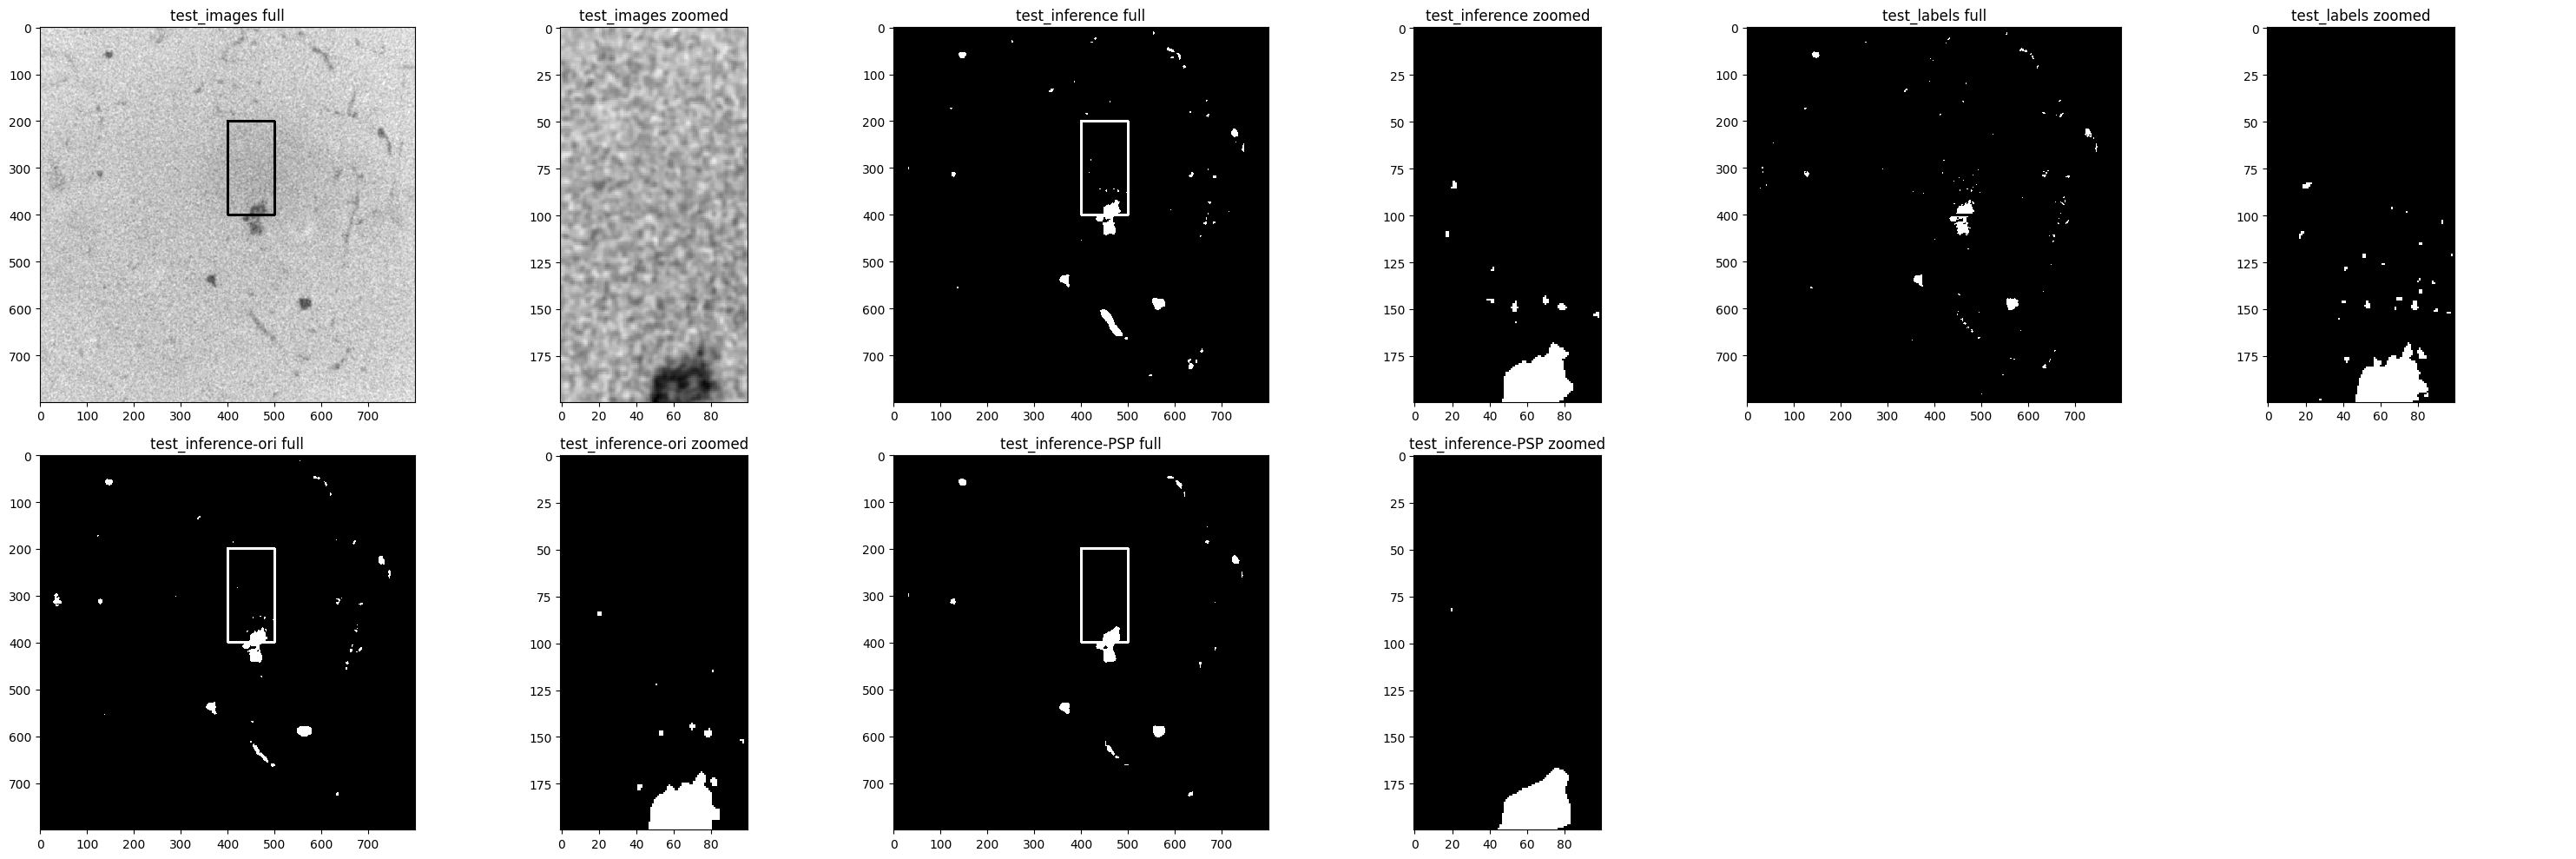

In [40]:
from API_functions.Visual import file_compare as fc
# %matplotlib qt

db = fc.ImageDatabase()
# image_processor.add_result('pre_processed', tpi.user_threshold(image_processor.image, 160))
zoom = fc.ZoomRegion(200, 400, 100, 200)
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/test_images/', 'test_images')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/test_labels/', 'test_labels')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference7/', 'test_inference')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference6/', 'test_inference-ori')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference8/', 'test_inference-PSP')
image_processor = db.get_image_processor('002_ou_DongYing_13636_roi_selected.png')
image_processor.show_images('test_images', 'test_inference', 'test_labels', "test_inference-ori", "test_inference-PSP", zoom_region=zoom)